# Phase 1 - EDA and Feature Selection

## 0. Import Libraries and define constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Statistical tools
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuration
sns.set_theme(style="whitegrid")

In [2]:
DATA_DIR = "../data/"
FILE_NAME = "Bitcoin_history_data.csv"
DATA_PATH = DATA_DIR + FILE_NAME

## 1. Historical Data Injection

In [3]:
df = pd.read_csv(DATA_PATH)

In [4]:
df.head()

Date       Close        High         Low        Open    Volume
0  2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
1  2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2  2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
3  2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
4  2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100

## 2. EDA and Feature Engineering 

### Getting to know the data

In [5]:
df.shape

(4161, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4161 non-null   object 
 1   Close   4161 non-null   float64
 2   High    4161 non-null   float64
 3   Low     4161 non-null   float64
 4   Open    4161 non-null   float64
 5   Volume  4161 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 195.2+ KB


We see that `Date` column is of str type. We need to convert it to datetime type for further analysis.

In [7]:
df["Date"] = pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4161 non-null   datetime64[ns]
 1   Close   4161 non-null   float64       
 2   High    4161 non-null   float64       
 3   Low     4161 non-null   float64       
 4   Open    4161 non-null   float64       
 5   Volume  4161 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 195.2 KB


In [8]:
df.head(10)

Date       Close        High         Low        Open    Volume
0 2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
1 2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2 2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
3 2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
4 2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100
5 2014-09-22  402.152008  406.915985  397.130005  399.100006  24127600
6 2014-09-23  435.790985  441.557007  396.196991  402.092010  45099500
7 2014-09-24  423.204987  436.112000  421.131989  435.751007  30627700
8 2014-09-25  411.574005  423.519989  409.467987  423.156006  26814400
9 2014-09-26  404.424988  414.937988  400.009003  411.428986  21460800

The columns in our dataset are as follows:
- `Date`: The specific timestamp for the data point.
- `Open`: The price at the very first second of that time period.
- `High`: The highest price of Bitcoin during that time period.
- `Low`: The lowest price of Bitcoin during that time period.
- `Close`: The price at the very last second of that time period.
- `Volume`: The total trading volume of Bitcoin during that time period.

In [9]:
df.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

We can see that there are no missing values in the dataset and all columns are of appropriate data types now.

In [10]:
df.describe()

Date          Close           High  \
count                           4161    4161.000000    4161.000000   
mean   2020-05-28 00:00:00.000000256   27388.727443   27919.286518   
min              2014-09-17 00:00:00     178.102997     211.731003   
25%              2017-07-23 00:00:00    2754.860107    2862.419922   
50%              2020-05-28 00:00:00   10938.271484   11206.439453   
75%              2023-04-03 00:00:00   42843.800781   43607.609375   
max              2026-02-06 00:00:00  124752.531250  126198.070312   
std                              NaN   32029.964953   32567.425521   

                 Low           Open        Volume  
count    4161.000000    4161.000000  4.161000e+03  
mean    26788.580979   27372.897893  2.186171e+10  
min       171.509995     176.897003  5.914570e+06  
25%      2679.729980    2738.520020  1.369310e+09  
50%     10622.921875   10933.752930  1.718486e+10  
75%     41950.941406   42840.890625  3.362757e+10  
max    123196.046875  124752.140625  3.509679e+11  
std     31438.090698   32026.378930  2.302784e+10

In our data we have records from `2014-09-17` to `2026-01-14` with a frequency of 1 day.

### Visualizations and Data Engineering

#### Key concepts for time series modeling

- Autocorrelation

- Seasonality

- Stationarity

##### Autocorrelation

Autocorrelation measures the degree to which current values correspond to the past values of historical data in a time series. High autocorrelation means that the current iteration of a time series maps closely to lagged versions. Autocorrelation identifies whether a time series repeats and can indicate seasonality. 

Autocorrelation can be positive or negative. Positive autocorrelation means that high values lead to higher values and low values lead to lower values. Negative autocorrelation is the opposite: high values follow low values and vice versa.




##### Checking for Autocorrelation

To check for autocorrelation in a time series, several methods can be employed. 

- Visual inspection using **autocorrelation function (ACF)** and **partial autocorrelation function (PACF)** plots provides an intuitive way to identify significant correlations at different lags, with spikes beyond the confidence bands indicating autocorrelation. 

- Statistically, the **Durbin-Watson test** measures autocorrelation on a scale where values near 2 indicate no autocorrelation, below 2 suggest positive autocorrelation, and above 2 suggest negative autocorrelation. The **Ljung-Box test** offers another approach, computing a p-value to determine if autocorrelations are statistically significant. 

For financial time series like Bitcoin prices, examining ACF/PACF plots combined with one of these statistical tests typically reveals whether past values meaningfully influence future values.

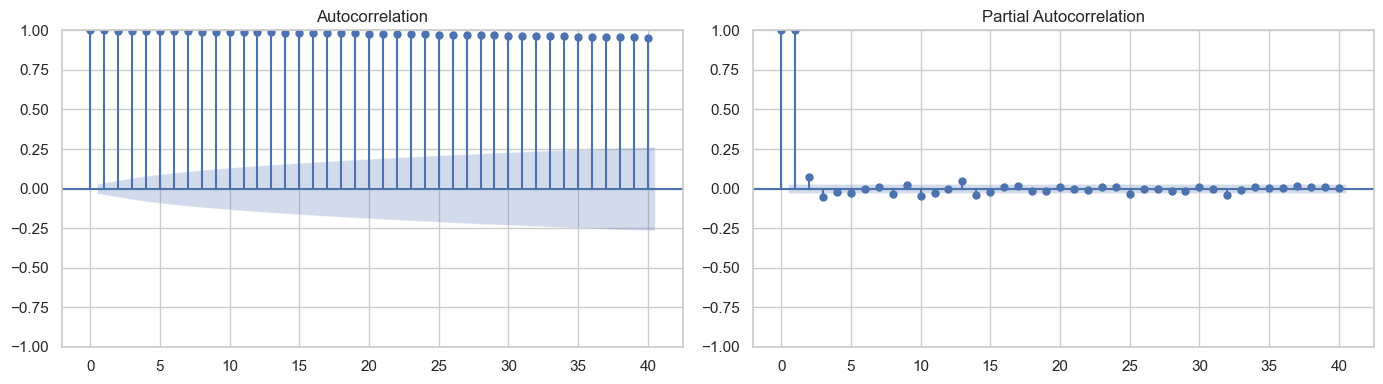

In [11]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df["Close"], lags=40, ax=axes[0])
plot_pacf(df["Close"], lags=40, ax=axes[1])

plt.tight_layout()
plt.show()

**Interpretation of the Plots:**

**Autocorrelation (Left Plot):**
The extremely high spikes across all lags (staying near 1.0) indicate very strong positive autocorrelation. This is typical for price data because prices don't change dramatically day-to-day—yesterday's price is highly predictive of today's price. The slow decay of the spikes suggests the data is non-stationary (i.e., has a trend), which is common in financial time series.

**Partial Autocorrelation (Right Plot):**
The PACF shows only a massive spike at lag 0 (which is always 1.0 by definition) and at lag 1, then drops to near zero for all other lags. This pattern indicates that once you account for the immediate past value (lag 1), there is little additional predictive power from further lags. This suggests an AR(1)-type structure, where today's price is primarily influenced by yesterday's price.

**What This Means:**
Bitcoin price data exhibits strong autocorrelation, which is expected and normal. The high ACF values indicate that prices are persistent—they trend upward or downward rather than fluctuate randomly. The PACF pattern suggests that if we model prices as depending on their immediate past value, we've captured most of the autocorrelation structure.

In [12]:
# Durbin-Watson test
dw = durbin_watson(df["Close"])

print(f"Durbin-Watson: {dw}")

# Ljung-Box test
lb_test = acorr_ljungbox(df["Close"], lags=10, return_df=True)
print(lb_test)

Durbin-Watson: 0.0007200206248629489
         lb_stat  lb_pvalue
1    4156.287683        0.0
2    8306.994462        0.0
3   12451.193201        0.0
4   16588.667698        0.0
5   20718.963318        0.0
6   24842.077463        0.0
7   28958.085680        0.0
8   33066.471268        0.0
9   37167.652710        0.0
10  41260.837554        0.0


**Interpretation of Durbin-Watson = 0.0007:**

This value is extremely close to 0, which indicates **very strong positive autocorrelation**. 

**Durbin-Watson Scale:**
- DW $\approx$ 2: No autocorrelation
- DW < 2: Positive autocorrelation (values tend to cluster together)
- DW > 2: Negative autocorrelation (values alternate)
- DW $\approx$ 0: Extremely strong positive autocorrelation

**Interpretation of Ljung-Box Test Results**:

All p-values are 0.0, which provides extremely strong statistical evidence of autocorrelation at every lag from 1 to 10.


**What This Means for the Data:**
A DW of 0.0007 confirms what the ACF/PACF plots showed—consecutive Bitcoin prices are highly dependent on each other. This makes sense because prices evolve gradually; they don't jump randomly. Today's price is almost certainly very similar to yesterday's price.

**Implications:**
This strong autocorrelation violates the independence assumption of many statistical models (like ordinary linear regression). If we're building predictive models or running statistical tests, we should either:
- Use **price returns** (daily percentage changes) instead of raw prices, which typically have much lower autocorrelation
- Use time series models like ARIMA or exponential smoothing that are designed to handle autocorrelated data
- Include lagged variables in our model to account for the dependency

The low DW value is not a problem - it's just a characteristic of price data that we need to account for in our analysis.

##### Seasonality

Seasonality is a characteristic of time series data in which there is a recurrent pattern based on a regular time interval—such as the changing of the seasons. For example, an e-commerce platform might sell more sunglasses in the spring and summer and more scarves in the fall and winter. Households typically use more electricity during the day than at night. 

Time-dependent seasonal variations are useful when predicting future values with forecasting models. Data visualization tools such as charts and graphs depict seasonality as a repeating fluctuation, often in the form of a sinusoidal wave. 

During time series data analysis, the decomposition process reveals any seasonality present in the data, as well as trends and noise. Trends are long-term increases or decreases in data values, while noise refers to random variations that don’t follow predictable patterns. Noise often stems from errors and outliers.


##### Checking for Seasonality

To detect seasonality in time series data, several approaches can be used. 

- Visual inspection through **time series decomposition** is the most direct method - decomposing the data into trend, seasonal, and residual components reveals the strength and pattern of seasonality. **Seasonal subseries plots**, which group data by season (e.g., by month or quarter) and display them separately, make recurring patterns visually obvious. Autocorrelation function (ACF) plots also reveal seasonality as regular spikes at seasonal lags - for example, spikes at lags 12, 24, 36 in monthly data suggest annual seasonality. 

- Statistical tests like the **seasonal subseries test** or the **Kruskal-Wallis test** can quantify whether seasonal differences are statistically significant. 

For financial data like Bitcoin prices, seasonality is often weaker than in commodity or retail data, but checking for daily, weekly, or monthly patterns using these methods can identify any recurring fluctuations tied to trading cycles or market behavior.

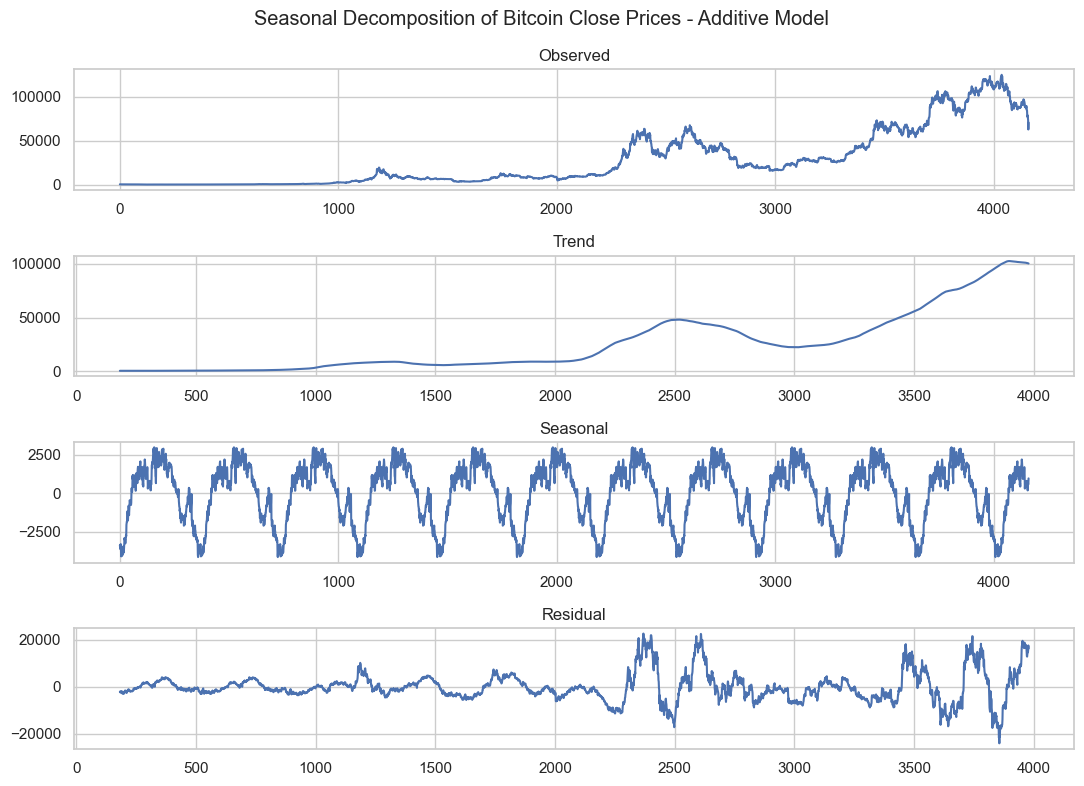

In [13]:
# Seasonal decomposition
decomposition = seasonal_decompose(df["Close"], model="additive", period=365)

fig, axes = plt.subplots(4, 1, figsize=(11, 8))

plt.suptitle("Seasonal Decomposition of Bitcoin Close Prices - Additive Model")
decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonal")
decomposition.resid.plot(ax=axes[3], title="Residual")
plt.tight_layout()
plt.show()

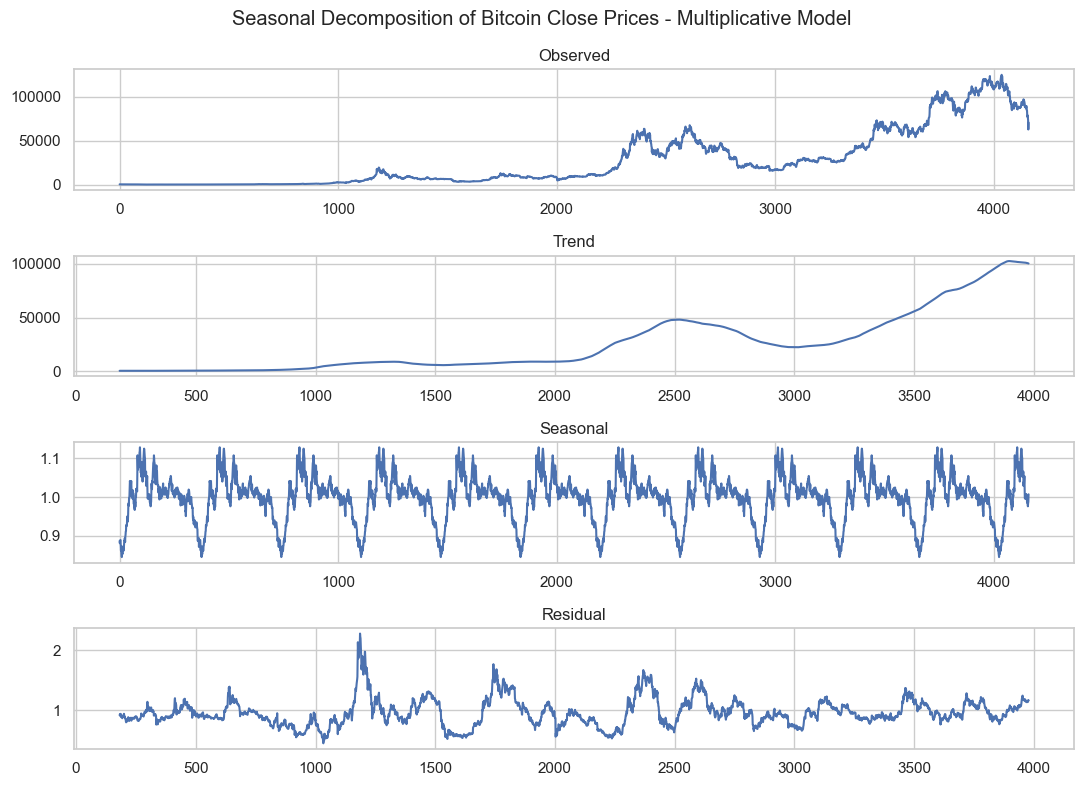

In [14]:
# Seasonal decomposition
decomposition = seasonal_decompose(df["Close"], model="multiplicative", period=365)

fig, axes = plt.subplots(4, 1, figsize=(11, 8))

plt.suptitle("Seasonal Decomposition of Bitcoin Close Prices - Multiplicative Model")
decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonal")
decomposition.resid.plot(ax=axes[3], title="Residual")
plt.tight_layout()
plt.show()

**Seasonal Decomposition**

For seasonal decomposition we have two models - additive and multiplicative.

- **Additive Model**: Assumes that the components (trend, seasonal, residual) add together to form the observed data. This model is appropriate when the seasonal fluctuations are roughly constant over time. The formula is:
  $Y_t = T_t + S_t + R_t$
Where:
    - $Y_t$ = Observed data at time t
    - $T_t$ = Trend component at time t
    - $S_t$ = Seasonal component at time t
    - $R_t$ = Residual component at time t

- **Multiplicative Model**: Assumes that the components multiply together to form the observed data. This model is suitable when the seasonal fluctuations increase or decrease proportionally with the level of the time series. The formula is:
  $Y_t = T_t * S_t * R_t$
Where:
    - $Y_t$ = Observed data at time t
    - $T_t$ = Trend component at time t
    - $S_t$ = Seasonal component at time t
    - $R_t$ = Residual component at time t

To calculate seasonal decomposition we need to follow a specific sequence of moving averages and substractions/divisions to isolate the trend, seasonal, and residual components based on the chosen model.

**Step 1: Calculate the Trend Component ($T_t$)**

- The trend is extracted using a Centered Moving Average (CMA) - this type of moving average centers the window around each data point.

    - The window size of the moving average is set to the period of the seasonality (e.g., 12 for monthly data, 365 for daily data).

    - This smooths out the "noise" and seasonal fluctuations, leaving behind the long-term direction of the data.

    - Note: This step results in NaN values at the beginning and end of the trend series because the window needs data points on both sides to calculate the average.

**Step 2: Calculate the "Detrended" Series**

Once we have the trend, we remove it from the original data to isolate the seasonality and noise.

- Additive: $Detrended = Y_t - T_t$

- Multiplicative: $Detrended = Y_t / T_t$

**Step 3: Calculate the Seasonal Component ($S_t$)**

To find the seasonal pattern, the algorithm looks at the detrended values for each specific period across all years.

1. Grouping and Averaging: 

The algorithm identifies every "Day 1" (Jan 1st) across  entire dataset — say, Jan 1st of 2020, 2021, 2022, etc. It takes the average of all the detrended values for those specific days. It then repeats this for all 365 days (or 366 for leap years).

2. The Seasonal "Profile"

The result is a single "Typical Year" profile. If we have 10 years of data, this profile is the distilled average of those 10 years. This is why seasonal_decompose is called a "static" model—it assumes that the impact of "July 12th" is the same in 2020 as it is in 2026.

3. Centering (The "Zero-Sum" Rule)

This is a crucial mathematical step. The algorithm ensures the seasonal effects don't artificially inflate the overall trend:

- Additive: It subtracts the mean from all 365 values so they sum to 0.

- Multiplicative: It divides by the mean so the average is 1.0.

4. Tiling

Finally, it "tiles" (copy-pastes) that 365-day average profile back-to-back until it covers the entire length of the original data.

**Step 4: Calculate the Residual Component ($R_t$)**

Finally, the residuals are calculated by removing both the trend and seasonal components from the original data.

- Additive: $R_t = Y_t - T_t - S_t$
- Multiplicative: $R_t = \frac{Y_t}{(T_t * S_t)}$


[]

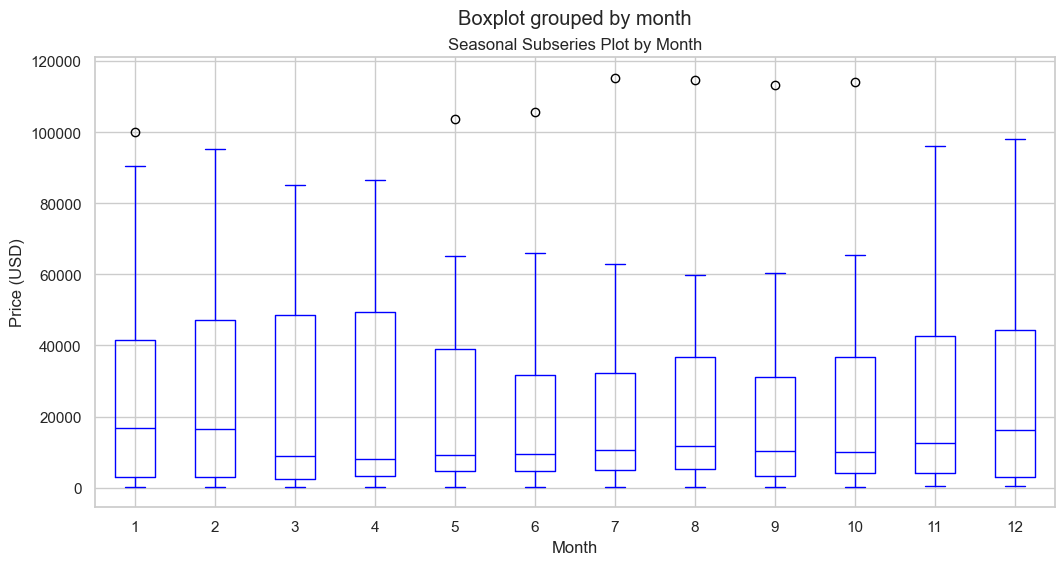

In [15]:
# Seasonal subseries plot
df_monthly = df.set_index("Date").resample("ME")["Close"].mean()
df_monthly = df_monthly.to_frame()
df_monthly["month"] = df_monthly.index.month
df_monthly.boxplot(by="month", figsize=(12, 6), color="blue")
plt.xlabel("Month")
plt.ylabel("Price (USD)")
plt.title("Seasonal Subseries Plot by Month")
plt.plot()

**Seasonal Subseries Plot Analysis:**

**Key Observations:**
- **Months 1-4 (Jan-Apr):** Higher median prices and wider price ranges, suggesting stronger performance in early year
- **Months 5-10 (May-Oct):** Lower median prices with tighter distributions, indicating weaker mid-year performance
- **Months 11-12 (Nov-Dec):** Prices rebound with wider ranges, suggesting year-end rally

**Conclusion:** Clear monthly seasonality exists — Bitcoin tends to perform better in Q1 (January-April) and Q4 (November-December), with weakness during mid-year months (May-October). This pattern could reflect trading cycles, institutional activity, or market sentiment tied to calendar quarters.

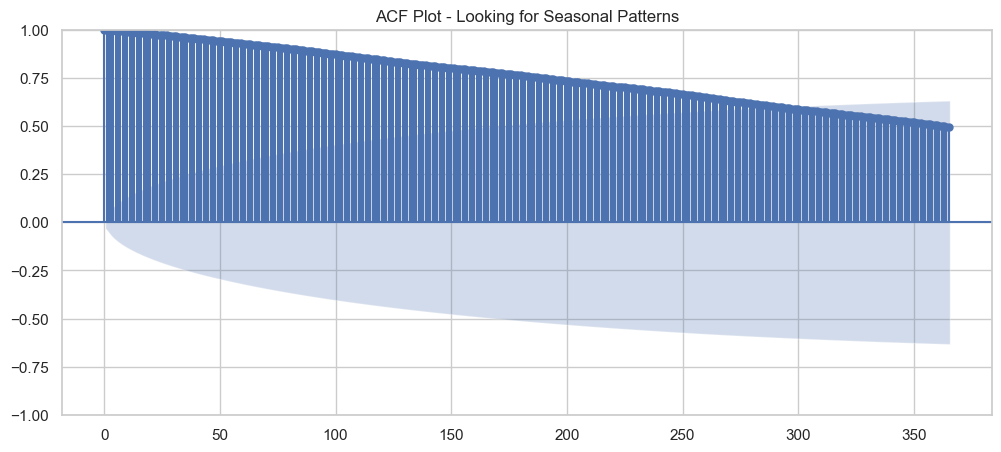

In [16]:
# ACF plot focusing on seasonal lags
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df["Close"], lags=365, ax=ax)
plt.title("ACF Plot - Looking for Seasonal Patterns")
plt.show()

**ACF Plot for Seasonality Analysis:**

**Key Observations:**
- **Uniform high spikes across all lags:** Every lag shows strong positive autocorrelation (0.5-1.0), declining gradually
- **No seasonal peaks:** Unlike typical seasonal data, there are no prominent regular spikes at specific intervals (e.g., lag 30, 365)
- **Slow decay:** The gradual decline indicates a strong trend dominates, masking any seasonal patterns

**Conclusion:** The ACF plot does **not show clear seasonal patterns**. The uniform high correlation reflects Bitcoin's strong trend and persistence rather than repeating seasonal cycles. While the subseries plot showed monthly seasonality, it's relatively weak compared to the overall trend.

##### Stationarity

A stationary time series has static statistical properties, such as the mean and variance. With stationarity, data points can fluctuate with seasonality, but there is no greater trend.

**Models Requiring Stationarity:**

Most traditional time series models require stationary data to produce reliable results. ARIMA models, exponential smoothing, and linear regression all assume stationarity. Violation of this assumption can lead to spurious correlations and poor forecasts. However, some modern approaches like LSTM neural networks are less sensitive to nonstationarity.

**Transforming Nonstationary Data:**

Time series datasets without stationarity can be transformed with techniques such as differencing (subtracting consecutive values) to remove trends, log transformation to stabilize variance, or detrending to isolate other patterns such as seasonality and autocorrelation.



##### Detecting Stationarity

- Visual inspection of time series plots reveals obvious trends and changing means or variances. 

- The **Augmented Dickey-Fuller (ADF) test** is the primary statistical method - a p-value below 0.05 indicates stationarity, while p-values above 0.05 suggest nonstationarity. The **KPSS test** provides an alternative perspective (null hypothesis is stationarity, opposite of ADF). 

Augmented Dickey-Fuller Test:
ADF Statistic: -1.249566486982411
P-value: 0.6519185908526189
Stationary: No

KPSS Test:
KPSS Statistic: 7.337009125813831
P-value: 0.01
Stationary: No

ADF Test on Differenced Data:
P-value: 6.487473911583286e-16
Stationary: Yes



/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_61999/4000379972.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df["Close"], regression="c", nlags="auto")


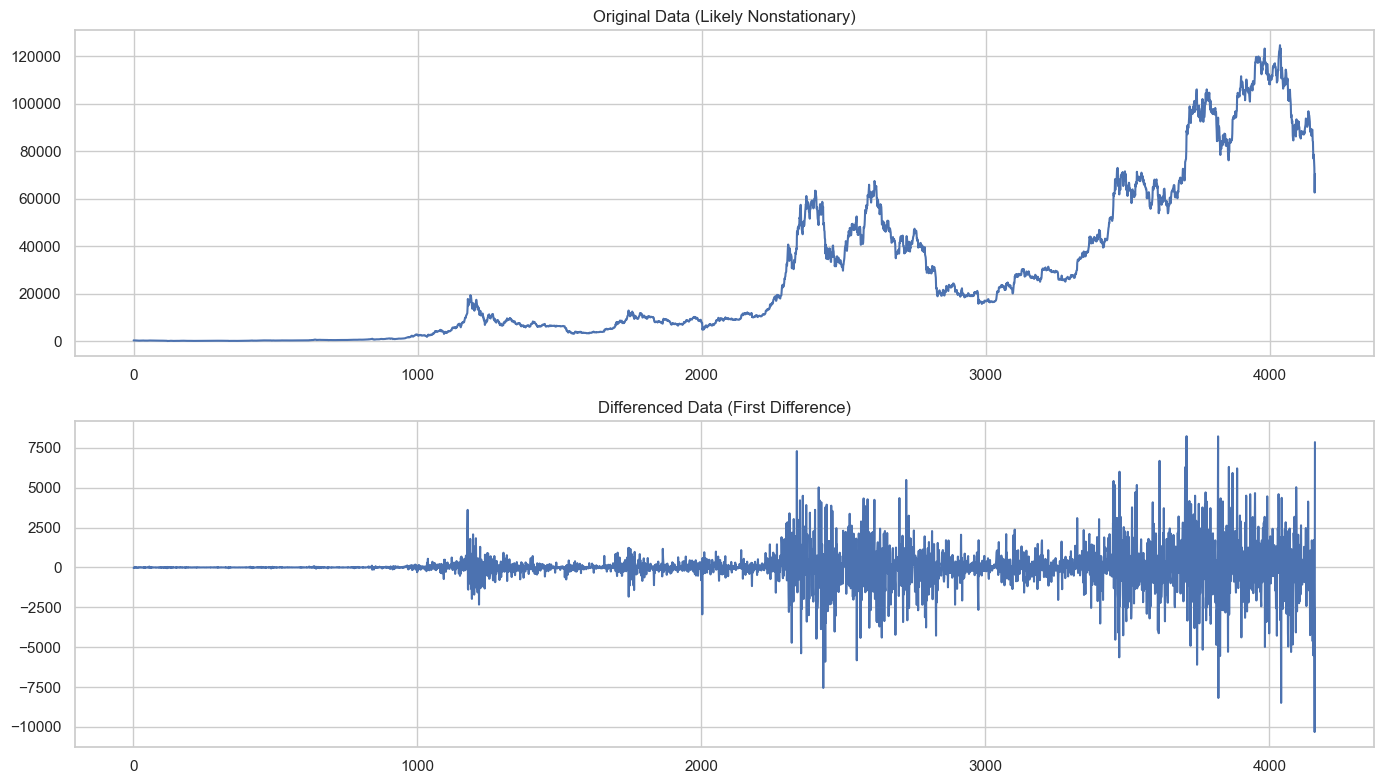

In [17]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(df["Close"], autolag="AIC")
print("Augmented Dickey-Fuller Test:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")
print(f"Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}\n")

# KPSS Test
kpss_result = kpss(df["Close"], regression="c", nlags="auto")
print("KPSS Test:")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"P-value: {kpss_result[1]}")
print(f"Stationary: {'Yes' if kpss_result[1] > 0.05 else 'No'}\n")

# Test on differenced data
df_diff = df["Close"].diff().dropna()
adf_diff = adfuller(df_diff, autolag="AIC")
print("ADF Test on Differenced Data:")
print(f"P-value: {adf_diff[1]}")
print(f"Stationary: {'Yes' if adf_diff[1] < 0.05 else 'No'}\n")

# Visual comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
df["Close"].plot(ax=axes[0], title="Original Data (Likely Nonstationary)")
df_diff.plot(ax=axes[1], title="Differenced Data (First Difference)")
plt.tight_layout()
plt.show()

**Stationarity Analysis:**

**Original Data:**

- **ADF Test (p-value = 0.89):** Fails to reject null hypothesis - data is **nonstationary**
- **KPSS Test (p-value = 0.01):** Rejects stationarity - confirms data is **nonstationary**
- **Visual:** Clear upward trend from near $0 to $120k, violating constant mean assumption

**Differenced Data:**
- **ADF Test (p-value $\approx$ 0):** Strongly rejects null hypothesis - differenced data is **stationary**
- **Visual:** Daily price changes fluctuate around zero with no trend, confirming stationarity

**Conclusion:** Bitcoin closing prices are highly nonstationary due to the strong upward trend. This makes raw prices unsuitable for traditional time series models like ARIMA without transformation. Taking first differences (daily returns) successfully removes the trend and achieves stationarity, making the data appropriate for forecasting models. For analysis, we should use **differenced data** or **log returns** instead of raw prices.

#### Other Visualizations and Feature Engineering

##### Candle Stick Chart

**Candle Stick Chart** is a chart that shows **how the price changed during a specific time period** using a single "candlestick".

Each candlestick shows four key prices:

* **Open** – price at the start of the period
* **Close** – price at the end
* **High** – the highest price
* **Low** – the lowest price

If the close is **higher** than the open -> candle is **green (price went up).**

If the close is **lower** than the open -> candle is **red (price went down).**




In [18]:
fig = go.Figure(
    data=go.Candlestick(
        x=df["Date"], open=df["Open"], high=df["High"], low=df["Low"], close=df["Close"]
    )
)

fig.update_layout(
    title="Bitcoin Price Candlestick Chart (2014-09-17 to 2026-01-14)",
    yaxis_title="Price (USD)",
)

fig.show()

**Bitcoin Candlestick Chart Summary:**

Bitcoin shows a strong upward trend from $0 to ~$90k over 11 years with significant volatility. Multiple boom-and-bust cycles are visible, with major peaks followed by sharp corrections. Volume increased notably during high-volatility periods.

We can see that range of Bitcoin price in years 2014-2021 is much smaller than in years 2021-2026. We will create two seperate candle stick charts to visualize this better.

In [19]:
# Chart for years 2014-2021
fig1 = go.Figure(
    data=go.Candlestick(
        x=df[df["Date"] < "2021-01-01"]["Date"],
        open=df[df["Date"] < "2021-01-01"]["Open"],
        high=df[df["Date"] < "2021-01-01"]["High"],
        low=df[df["Date"] < "2021-01-01"]["Low"],
        close=df[df["Date"] < "2021-01-01"]["Close"],
    )
)

fig1.update_layout(
    title="Bitcoin Price Candlestick Chart (2014-2021)", yaxis_title="Price (USD)"
)

fig1.show()

# Chart for years 2021-2026
fig2 = go.Figure(
    data=go.Candlestick(
        x=df[df["Date"] >= "2021-01-01"]["Date"],
        open=df[df["Date"] >= "2021-01-01"]["Open"],
        high=df[df["Date"] >= "2021-01-01"]["High"],
        low=df[df["Date"] >= "2021-01-01"]["Low"],
        close=df[df["Date"] >= "2021-01-01"]["Close"],
    )
)

fig2.update_layout(
    title="Bitcoin Price Candlestick Chart (2021-2026)", yaxis_title="Price (USD)"
)

fig2.show()

##### Line Chart of Closing Prices

**Line chart of closing prices** over time shows the overall trend of prices at the end of each day. It helps identify patterns like upward or downward trends, volatility, and significant price movements over the entire period.

**Moving average line** smooths out short-term fluctuations and highlights longer-term trends by averaging closing prices over a specified period (e.g., 30 days).

In [20]:
# Feature Engineering - Moving Averages

df["SMA_7"] = df["Close"].rolling(window=7).mean()
df["SMA_30"] = df["Close"].rolling(window=30).mean()
df["SMA_100"] = df["Close"].rolling(window=100).mean()

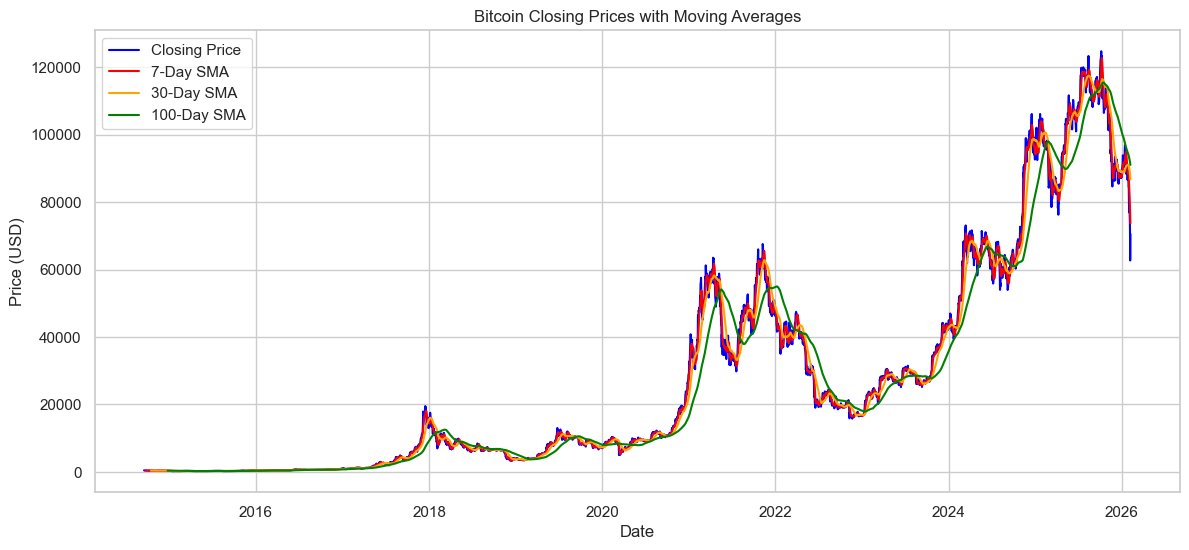

In [21]:
plt.figure(figsize=(14, 6))

plt.plot(df["Date"], df["Close"], label="Closing Price", color="blue")
plt.plot(df["Date"], df["SMA_7"], label="7-Day SMA", color="red")
plt.plot(df["Date"], df["SMA_30"], label="30-Day SMA", color="orange")
plt.plot(df["Date"], df["SMA_100"], label="100-Day SMA", color="green")

plt.title("Bitcoin Closing Prices with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

**Moving Averages Summary:**

The 7-day SMA closely follows price movements, the 30-day SMA smooths short-term volatility, and the 100-day SMA defines the long-term trend. All three converge during stable periods and diverge during high volatility.

We will also take a look at moving averages for each year separately to see how trends evolved over time.

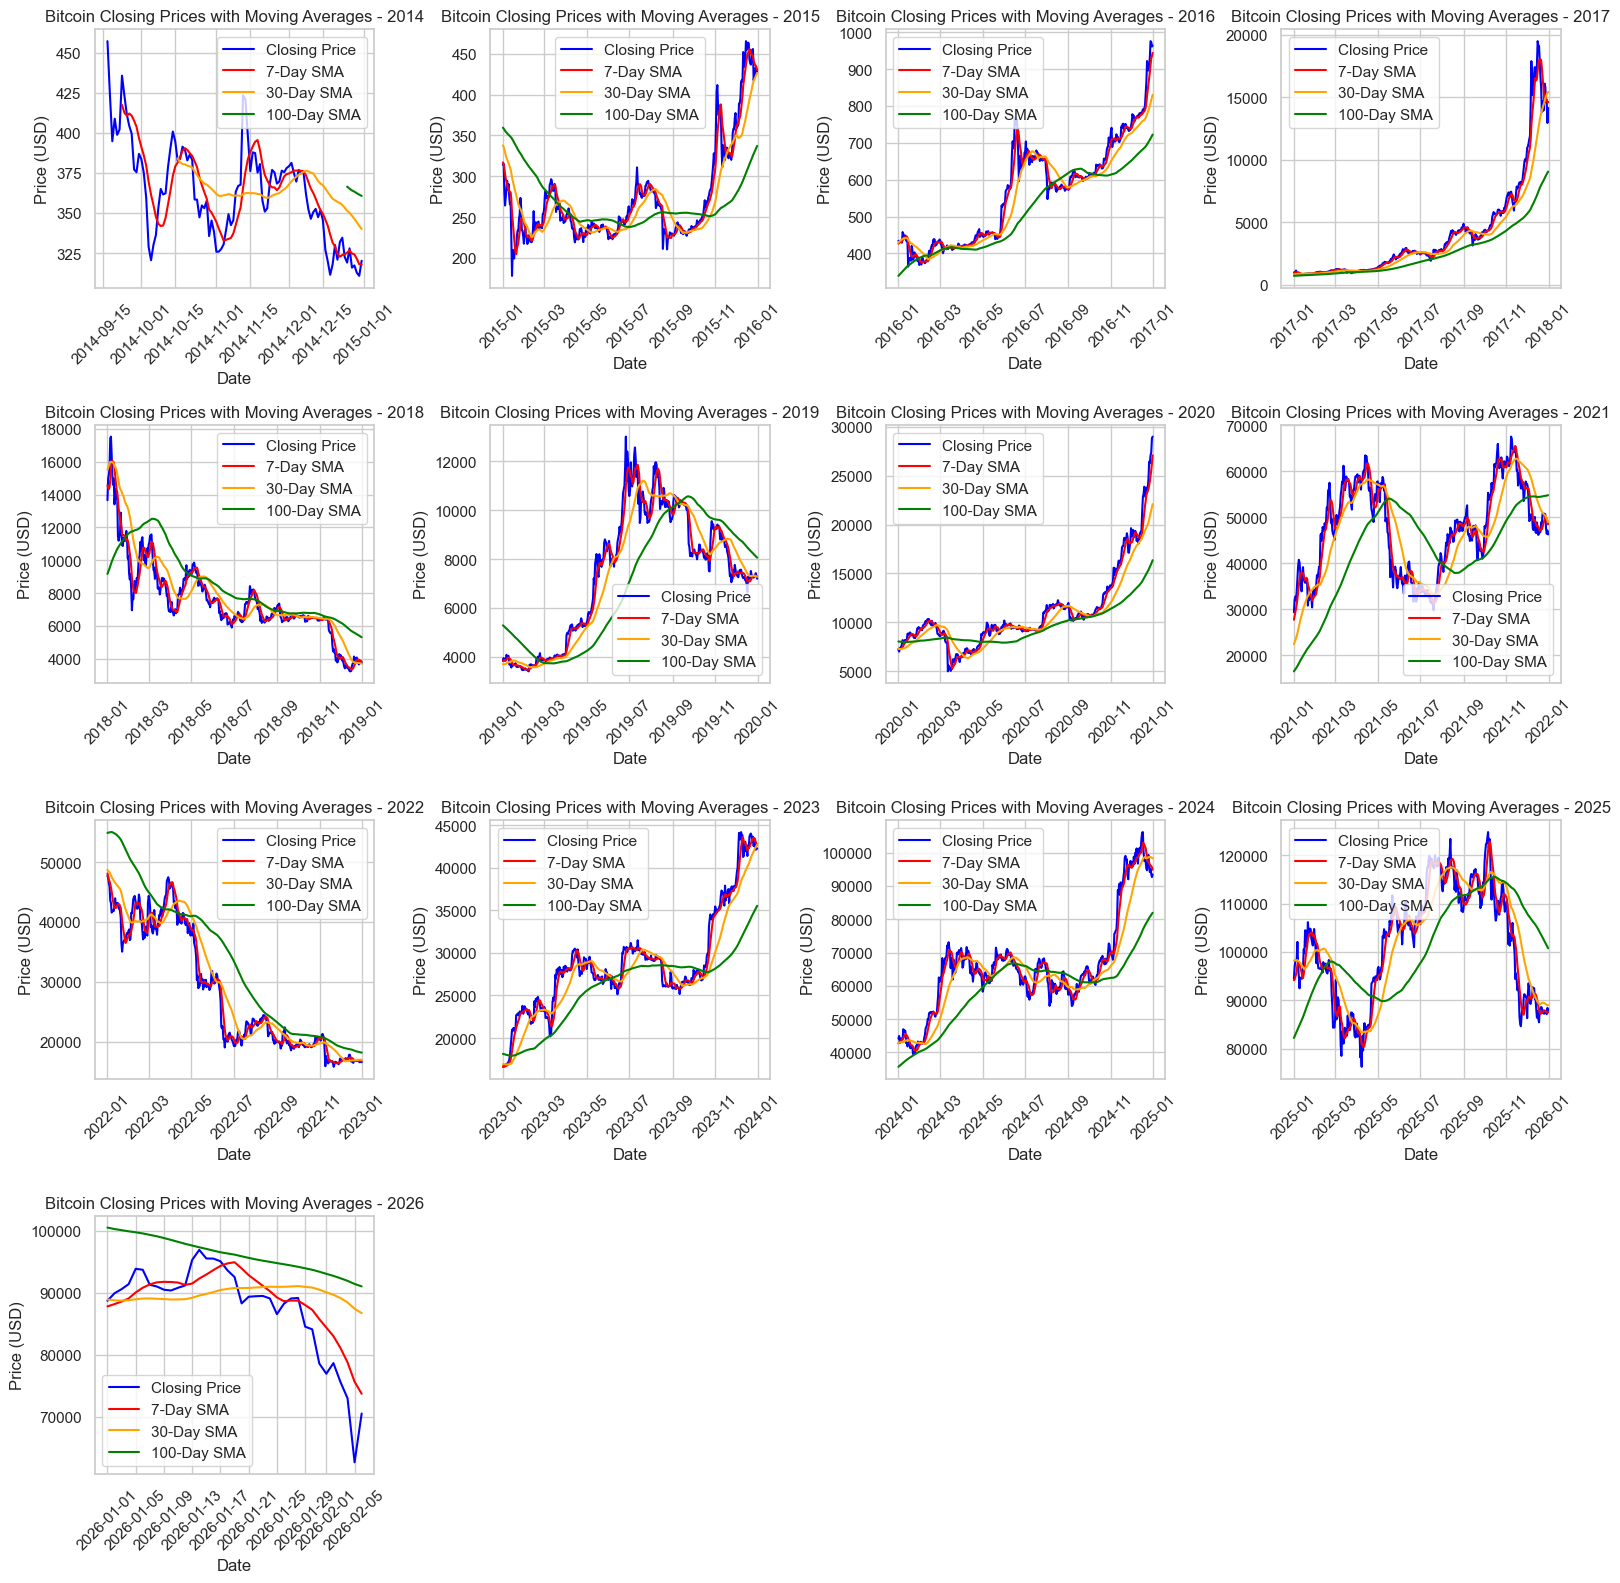

In [22]:
years_with_data = [
    year for year in range(2014, 2027) if not df[df["Date"].dt.year == year].empty
]

num_plots = len(years_with_data)

# Grid layout
cols = 4
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

for idx, year in enumerate(years_with_data):
    yearly_data = df[df["Date"].dt.year == year]
    ax = axes[idx]

    ax.plot(
        yearly_data["Date"], yearly_data["Close"], label="Closing Price", color="blue"
    )
    ax.plot(yearly_data["Date"], yearly_data["SMA_7"], label="7-Day SMA", color="red")
    ax.plot(
        yearly_data["Date"], yearly_data["SMA_30"], label="30-Day SMA", color="orange"
    )
    ax.plot(
        yearly_data["Date"], yearly_data["SMA_100"], label="100-Day SMA", color="green"
    )

    ax.set_title(f"Bitcoin Closing Prices with Moving Averages - {year}")
    ax.set_xlabel("Date")
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylabel("Price (USD)")
    ax.legend()

# Hide empty subplots
for idx in range(num_plots, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

##### Volume Chart

**Volume chart** shows the total trading volume for each day. It helps identify periods of high and low trading activity, which can indicate market interest and potential price movements.

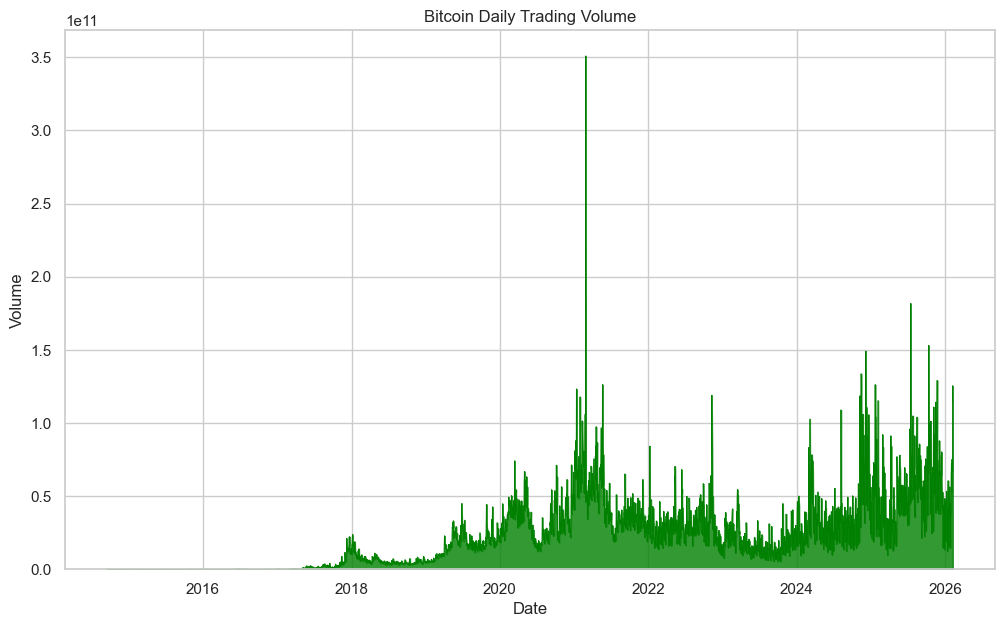

In [23]:
plt.figure(figsize=(12, 7))

# Volume area plot
plt.fill_between(df["Date"], df["Volume"], color="green", alpha=0.8)
plt.plot(df["Date"], df["Volume"], color="green", linewidth=0.5)
plt.title("Bitcoin Daily Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.ylim(bottom=0)
plt.show()

**Bitcoin Daily Trading Volume Summary:**

Trading volume remained minimal until 2017, then increased significantly from 2018 onwards. Peak volume occurred around 2021 with a dramatic spike indicating intense trading activity. Volume declined during 2022 but rebounded in 2024-2025. Overall, volume spikes correlate with price volatility and major market events, with higher activity during bull markets and periods of rapid price movement.

Let us also take a look at volume for each year separately to see how trading activity evolved over time.

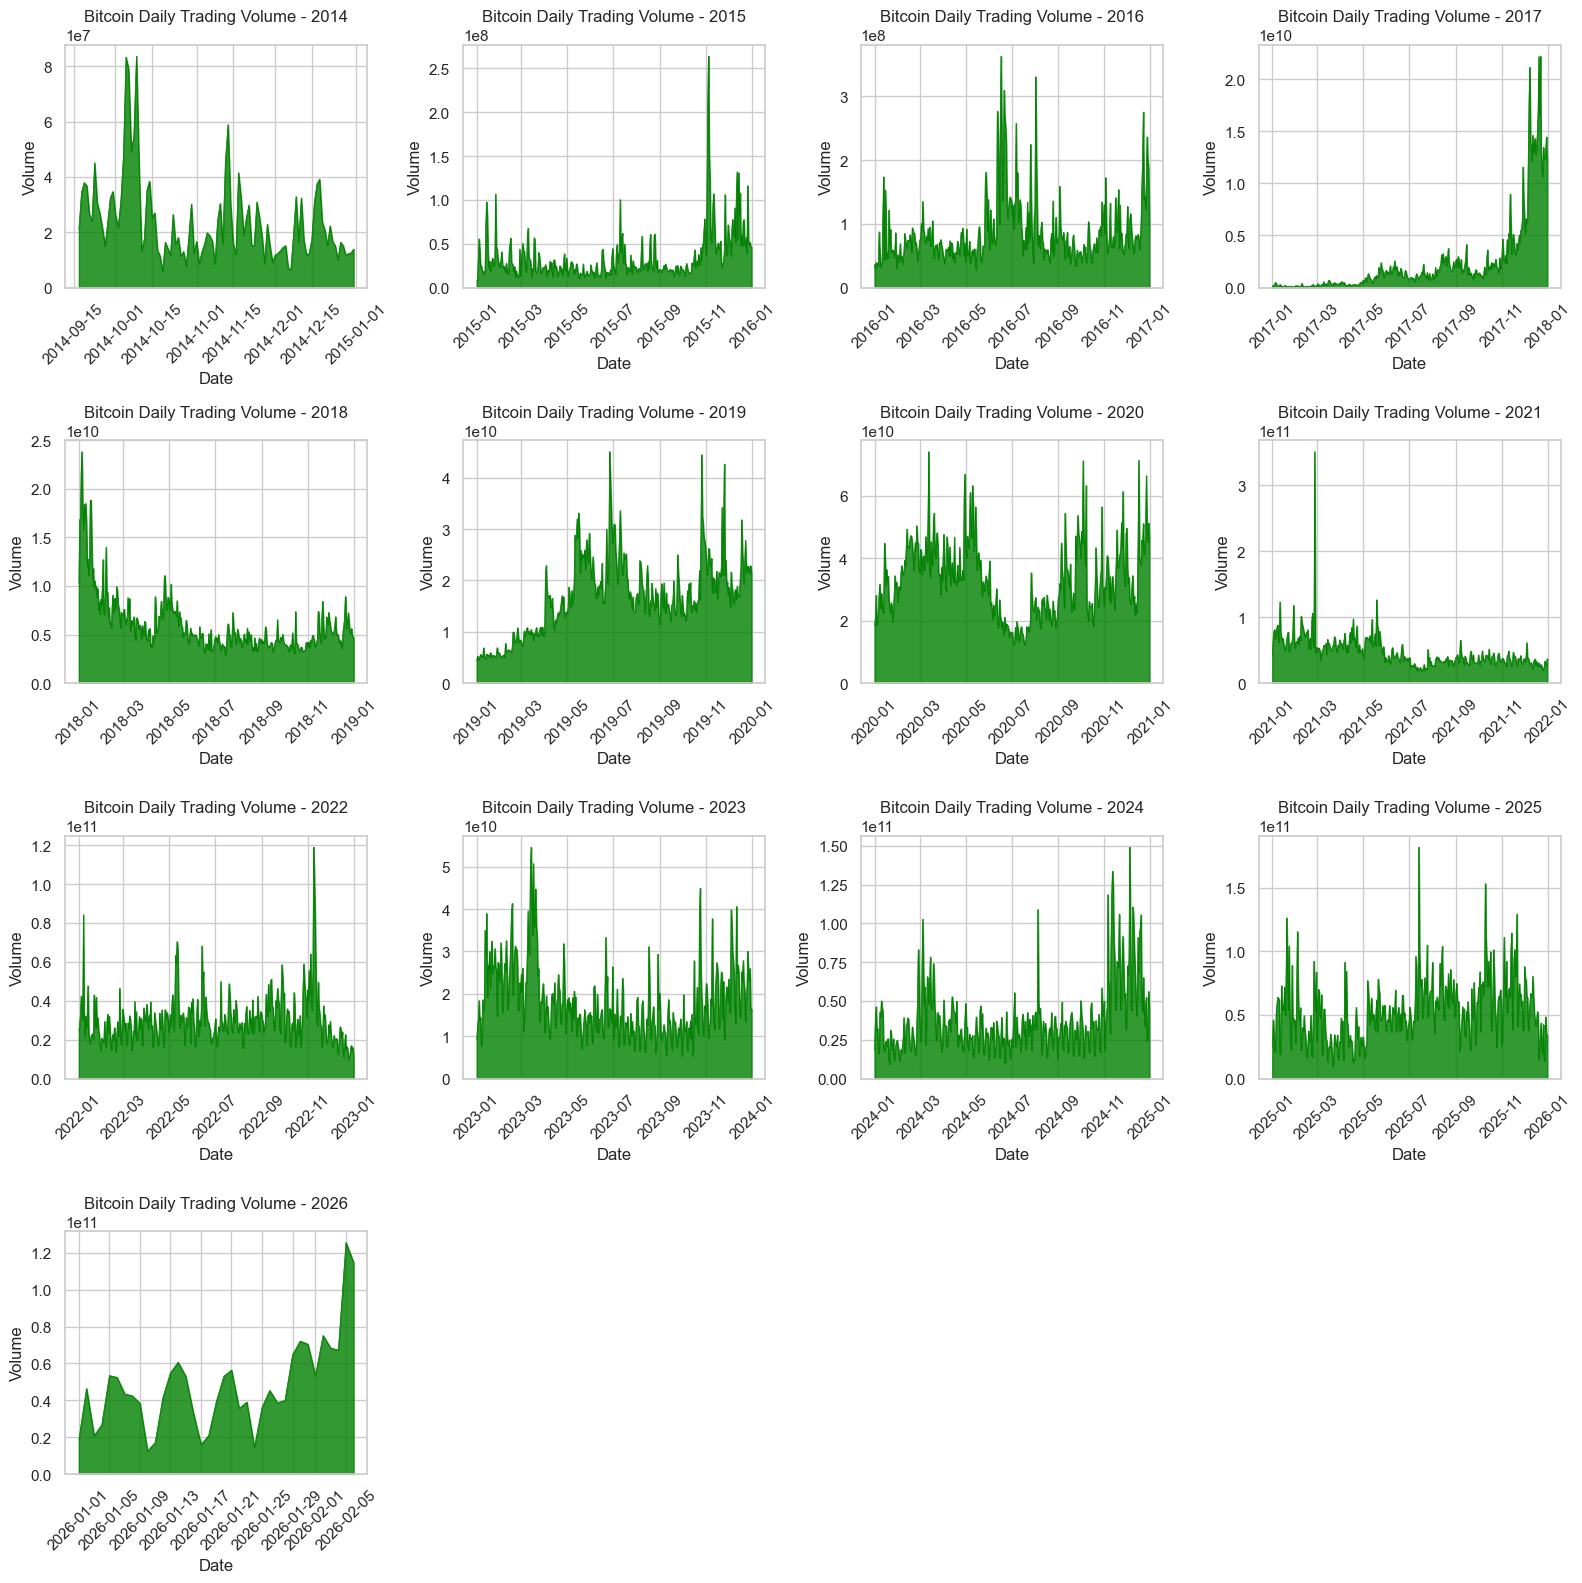

In [24]:
# Grid layout
cols = 4
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()

for idx, year in enumerate(years_with_data):
    yearly_data = df[df["Date"].dt.year == year]
    ax = axes[idx]

    ax.fill_between(
        yearly_data["Date"], yearly_data["Volume"], color="green", alpha=0.8
    )
    ax.plot(yearly_data["Date"], yearly_data["Volume"], color="green", linewidth=0.5)
    ax.set_title(f"Bitcoin Daily Trading Volume - {year}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Volume")
    ax.set_ylim(bottom=0)
    ax.tick_params(axis="x", rotation=45)

# Hide empty subplots
for idx in range(num_plots, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

##### Closing Pice and Volume Plot

We will also check whether there is any correlation between closing price and volume.

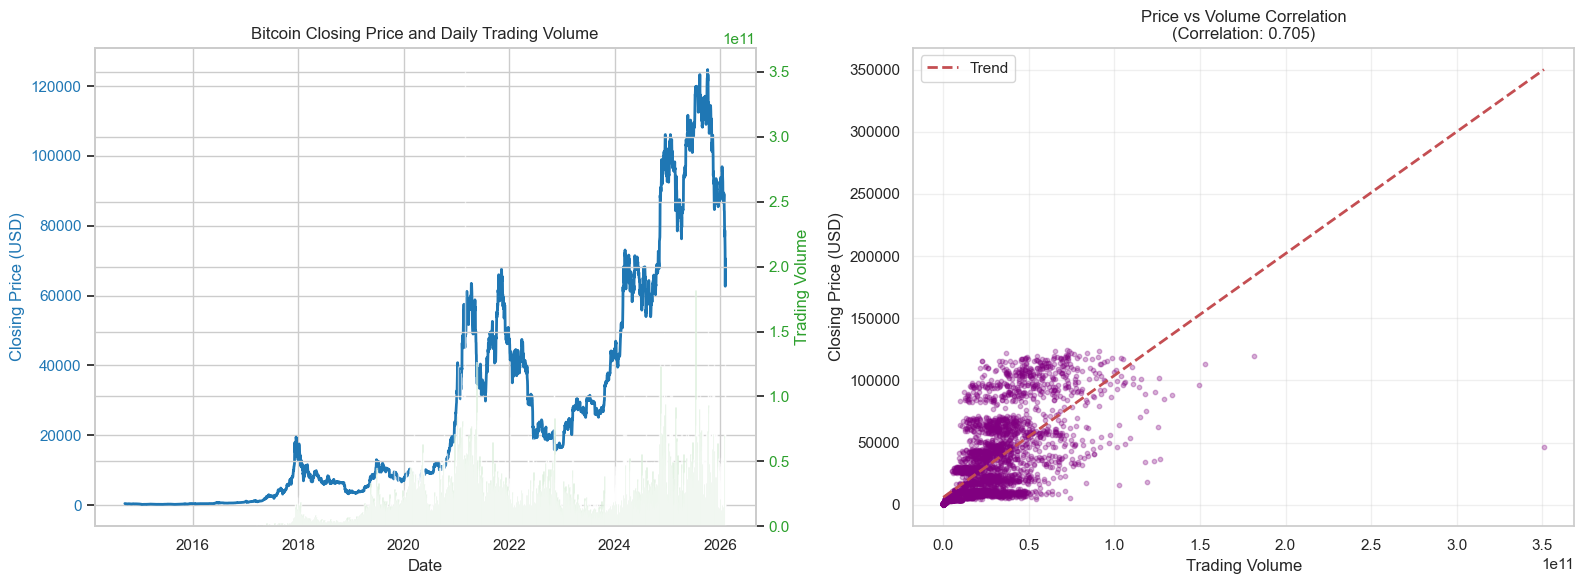

In [25]:
# Correlation between Price and Volume
correlation = df["Close"].corr(df["Volume"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Price and Volume
color = "tab:blue"
ax1.plot(df["Date"], df["Close"], color=color, linewidth=2, label="Closing Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price (USD)", color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax1_twin = ax1.twinx()
color = "tab:green"
ax1_twin.bar(df["Date"], df["Volume"], color=color, alpha=0.6, width=1, label="Volume")
ax1_twin.set_ylabel("Trading Volume", color=color)
ax1_twin.tick_params(axis="y", labelcolor=color)
ax1.set_title("Bitcoin Closing Price and Daily Trading Volume")

# Right plot: Correlation scatter
ax2.scatter(df["Volume"], df["Close"], alpha=0.3, s=10, color="purple")
ax2.set_xlabel("Trading Volume")
ax2.set_ylabel("Closing Price (USD)")
ax2.set_title(f"Price vs Volume Correlation\n(Correlation: {correlation:.3f})")
ax2.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df["Volume"], df["Close"], 1)
p = np.poly1d(z)
ax2.plot(
    sorted(df["Volume"]), p(sorted(df["Volume"])), "r--", linewidth=2, label="Trend"
)
ax2.legend()

plt.tight_layout()
plt.show()

**Bitcoin Price and Volume Relationship**

The correlation coefficient of 0.705 indicates a **strong positive relationship** between Bitcoin price and trading volume. As prices increase, trading volume tends to increase correspondingly, and vice versa. 

The scatter plot shows this pattern clearly - higher prices are generally associated with higher volume. However, the wide spread of points at similar price levels reveals that the relationship is not perfectly linear; volume varies considerably even at the same price points, suggesting other factors also influence trading activity beyond price alone.

##### Momentum Indicators

To better understand Bitcoin's price movements and market conditions, we can analyze two key momentum indicators:

 **RSI** measures overbought and oversold conditions to identify potential reversals, while **MACD** tracks trend changes and momentum shifts through the convergence and divergence of moving averages. 
 
 Together, they provide insight into both extreme price conditions and directional momentum changes. The closing price chart with moving averages serves as context for understanding these momentum signals within the overall price trend.

##### RSI (Relative Strength Index) Chart

**Relative Strength Index (RSI)** is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and is typically used to identify overbought or oversold conditions in a market.

The formula to calculate RSI is:

$RSI = 100 - \left( \frac{100}{1 + RS} \right)$

Where: $RS$ (Relative Strength) = Average Gain / Average Loss over a specified period (commonly 14 days).



##### MACD (Moving Average Convergence Divergence) Chart

**MACD** is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMA). 

It consists of three components: 
- the **MACD line** (12-day EMA minus 26-day EMA), 
- the **signal line** (9-day EMA of MACD),
- the **histogram** (difference between MACD and signal line). 

When the MACD line crosses above the signal line, it signals bullish momentum (prices rising); when it crosses below, it signals bearish momentum (prices falling). The histogram visualizes the strength of the trend, with larger values indicating stronger momentum.

##### Note on EMA (Exponential Moving Average)
Unlike simple moving averages that treat all data points equally, an EMA gives more weight to recent prices, making it more responsive to recent price changes. This makes EMAs particularly useful for trend-following indicators like MACD, as they react faster to momentum shifts while still smoothing out short-term noise.

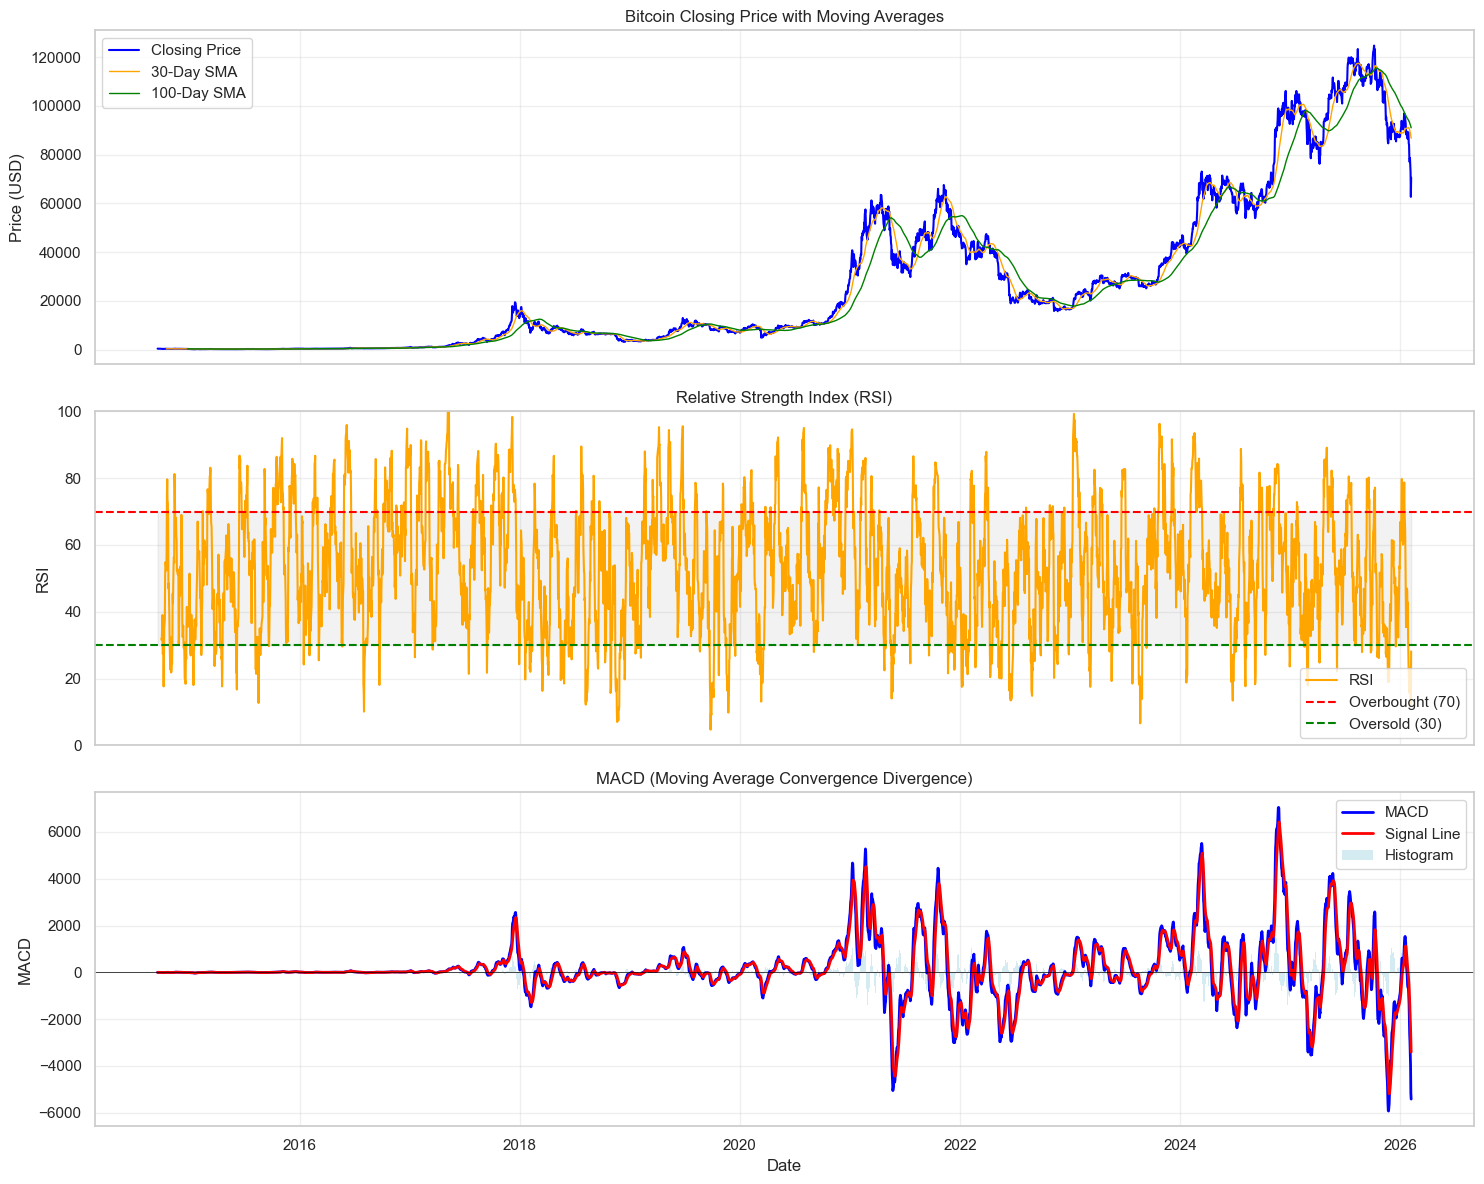

In [26]:
# RSI Calculation
delta = df["Close"].diff()
delta = delta.astype(float)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# MACD Calculation
ema_12 = df["Close"].ewm(span=12).mean()
ema_26 = df["Close"].ewm(span=26).mean()
df["MACD"] = ema_12 - ema_26
df["Signal"] = df["MACD"].ewm(span=9).mean()
df["MACD_Hist"] = df["MACD"] - df["Signal"]

# Create 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Chart 1: Closing Price with Moving Averages
ax1.plot(df["Date"], df["Close"], label="Closing Price", color="blue", linewidth=1.5)
ax1.plot(df["Date"], df["SMA_30"], label="30-Day SMA", color="orange", linewidth=1)
ax1.plot(df["Date"], df["SMA_100"], label="100-Day SMA", color="green", linewidth=1)
ax1.set_ylabel("Price (USD)")
ax1.set_title("Bitcoin Closing Price with Moving Averages")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Chart 2: RSI
ax2.plot(df["Date"], df["RSI"], label="RSI", color="orange", linewidth=1.5)
ax2.axhline(70, color="red", linestyle="--", label="Overbought (70)")
ax2.axhline(30, color="green", linestyle="--", label="Oversold (30)")
ax2.fill_between(df["Date"], 30, 70, alpha=0.1, color="gray")
ax2.set_ylabel("RSI")
ax2.set_title("Relative Strength Index (RSI)")
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Chart 3: MACD
ax3.bar(
    df["Date"],
    df["MACD_Hist"],
    label="Histogram",
    color="lightblue",
    alpha=0.5,
    width=1,
    edgecolor="none",
)
ax3.plot(df["Date"], df["MACD"], label="MACD", color="blue", linewidth=2)
ax3.plot(df["Date"], df["Signal"], label="Signal Line", color="red", linewidth=2)
ax3.axhline(0, color="black", linestyle="-", linewidth=0.5)
ax3.set_ylabel("MACD")
ax3.set_xlabel("Date")
ax3.set_title("MACD (Moving Average Convergence Divergence)")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Technical Indicators Analysis:**

**RSI:** Oscillates frequently between 20-90 and even above 90 and below 10, indicating high volatility. Spikes above 70 signal overbought conditions (potential pullbacks), while dips below 30 signal oversold conditions (potential bounces). The indicator rarely stays in the neutral 40-60 range, reflecting Bitcoin's volatile nature.

**MACD:** The MACD line and signal line cross multiple times, indicating frequent momentum shifts. Positive histogram bars (bullish) dominate during uptrends (2017, 2021, 2024), while negative bars (bearish) appear during downtrends (2018, 2022).

#### Time-based Features

Time-based features extract temporal patterns from the data, such as day of week, month, and seasonal effects, to identify whether Bitcoin trading activity and price movements follow predictable calendar-based cycles.

In [27]:
# Extract date features

# Base features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek

# Sine and Cosine transformations for cyclical features
df["Month_Sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_Cos"] = np.cos(2 * np.pi * df["Month"] / 12)

df["DayOfWeek_Sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 7)
df["DayOfWeek_Cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 7)

##### Seasonal Patterns Plots

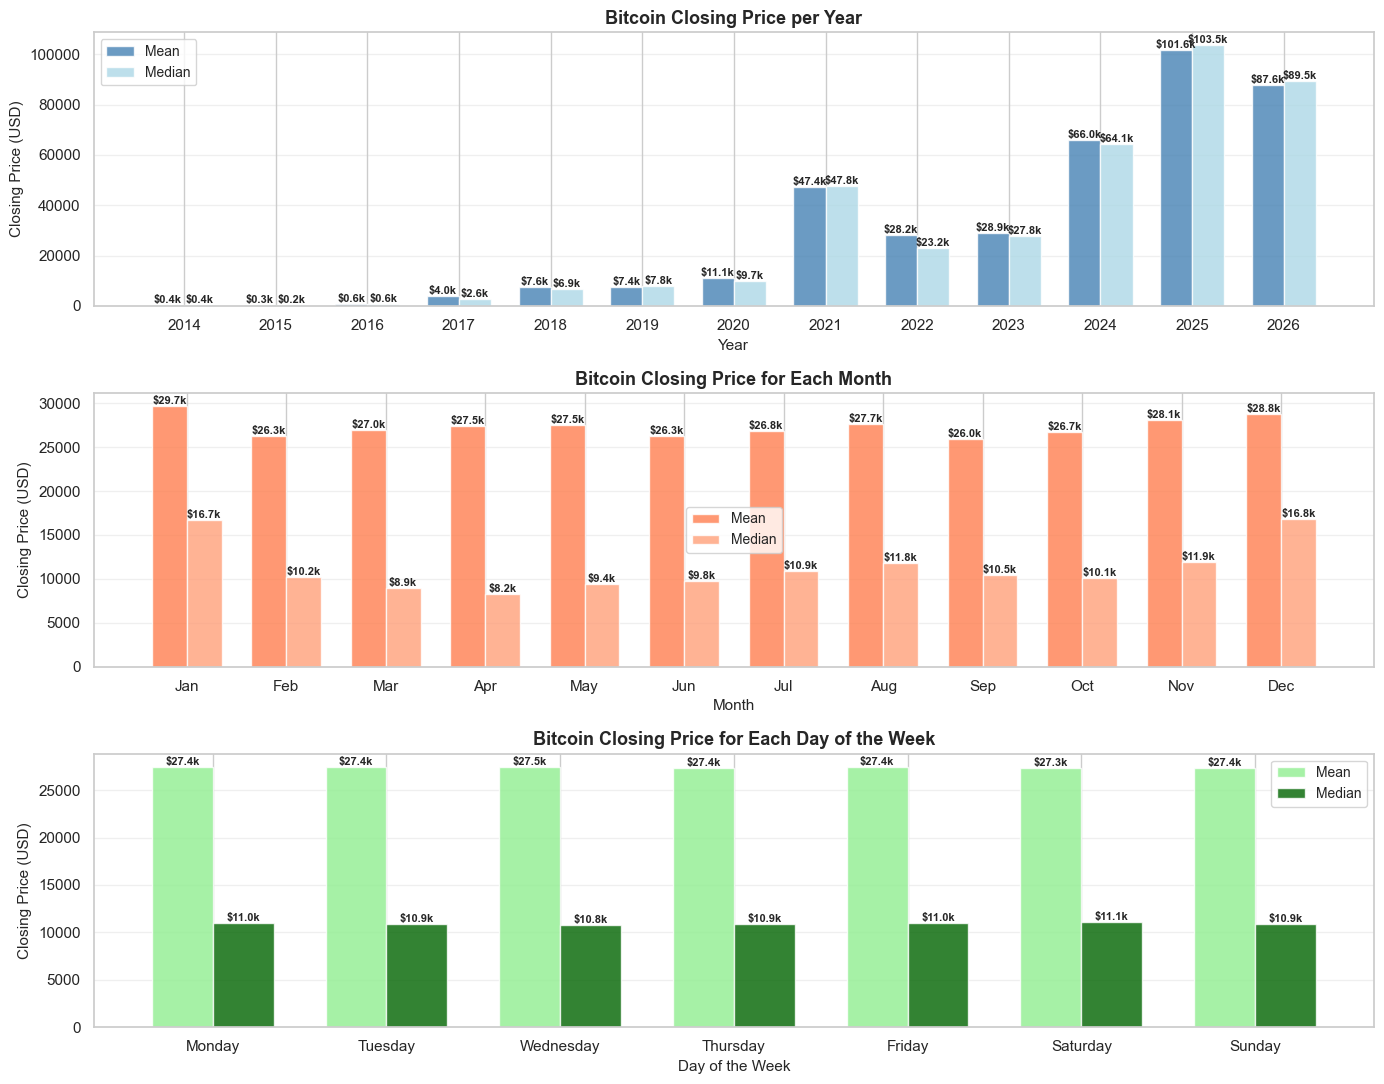

In [28]:
# Data preparation for plots
df_yearly = df.groupby("Year")["Close"].agg(["mean", "median"]).reset_index()
df_yearly.rename(
    columns={"mean": "Mean_Close_Price", "median": "Median_Close_Price"}, inplace=True
)

df_monthly = df.groupby("Month")["Close"].agg(["mean", "median"]).reset_index()
df_monthly.rename(
    columns={"mean": "Mean_Close_Price", "median": "Median_Close_Price"}, inplace=True
)

df_weekly = df.groupby("DayOfWeek")["Close"].agg(["mean", "median"]).reset_index()
df_weekly.rename(
    columns={"mean": "Mean_Close_Price", "median": "Median_Close_Price"}, inplace=True
)

# Create 3x1 grid
fig, axes = plt.subplots(3, 1, figsize=(14, 11))


# Helper function to create grouped bars with labels
def plot_grouped_bars(ax, data, x_col, title, x_label, colors=("steelblue", "coral")):
    x = np.arange(len(data))
    width = 0.35

    bars1 = ax.bar(
        x - width / 2,
        data["Mean_Close_Price"],
        width,
        label="Mean",
        color=colors[0],
        alpha=0.8,
    )
    bars2 = ax.bar(
        x + width / 2,
        data["Median_Close_Price"],
        width,
        label="Median",
        color=colors[1],
        alpha=0.8,
    )

    ax.set_title(title, fontweight="bold", fontsize=13)
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel("Closing Price (USD)", fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(data[x_col])
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"${height / 1000:.1f}k",
                ha="center",
                va="bottom",
                fontsize=8,
                fontweight="bold",
            )

    return bars1, bars2


# Plot 1: Mean and Median Bitcoin Closing Price per Year
plot_grouped_bars(
    ax=axes[0],
    data=df_yearly,
    x_col="Year",
    title="Bitcoin Closing Price per Year",
    x_label="Year",
    colors=("steelblue", "lightblue"),
)

# Plot 2: Mean and Median Bitcoin Closing Price per Month
month_labels = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
df_monthly["Month_Label"] = df_monthly["Month"].apply(
    lambda x: month_labels[int(x) - 1]
)

plot_grouped_bars(
    ax=axes[1],
    data=df_monthly,
    x_col="Month_Label",
    title="Bitcoin Closing Price for Each Month",
    x_label="Month",
    colors=("coral", "lightsalmon"),
)

# Plot 3: Mean and Median Bitcoin Closing Price per Day of Week
day_labels = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
df_weekly["DayOfWeek_Label"] = df_weekly["DayOfWeek"].apply(
    lambda x: day_labels[int(x)]
)

plot_grouped_bars(
    ax=axes[2],
    data=df_weekly,
    x_col="DayOfWeek_Label",
    title="Bitcoin Closing Price for Each Day of the Week",
    x_label="Day of the Week",
    colors=("lightgreen", "darkgreen"),
)

plt.tight_layout()
plt.show()

**Seasonal Patterns: Price Levels by Year, Month, and Day of Week**

**Yearly trends** show exponential Bitcoin growth from $0.4k (2014) to $101.6k (2025), with 2021 marking the previous bull market peak at $47.4k. 

**Monthly analysis** reveals minimal seasonality with prices clustering around $26-28k across all months, suggesting no strong monthly trading advantage. 

**Weekly patterns** are similarly flat at ~$27k per day, with no significant day-of-week effect.


##### Boxplot of Closing Prices for Each Year


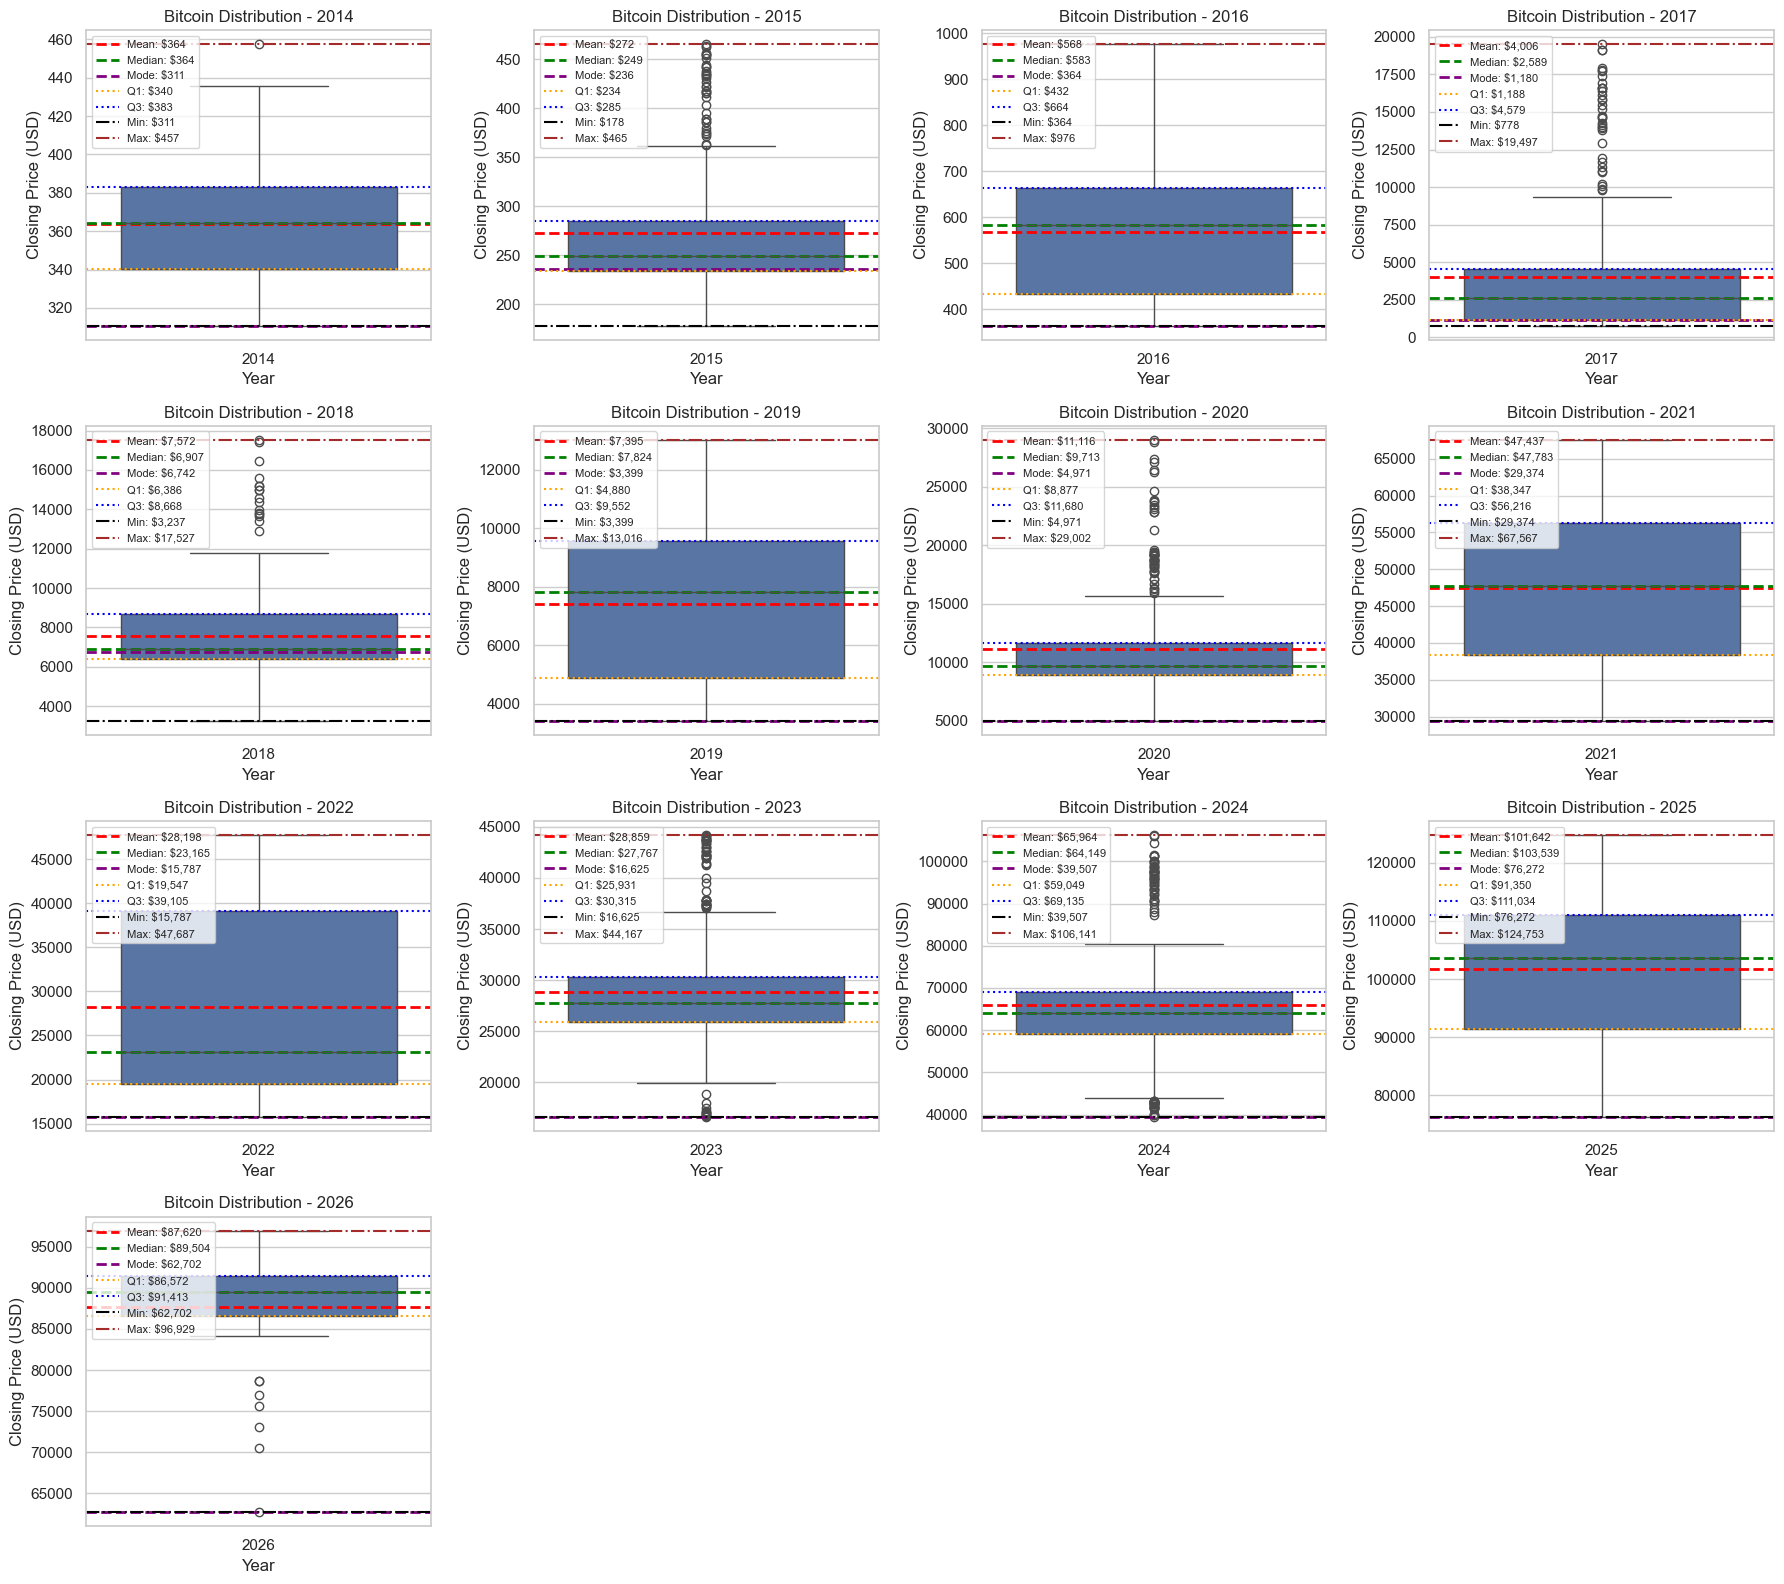

In [29]:
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

for idx, year in enumerate(years_with_data):
    yearly_data = df[df["Date"].dt.year == year].copy()
    yearly_data["Year"] = year
    ax = axes[idx]

    # Boxplot
    sns.boxplot(x="Year", y="Close", data=yearly_data, ax=ax)

    # Calculate statistics
    mean_val = yearly_data["Close"].mean()
    median_val = yearly_data["Close"].median()
    mode_val = stats.mode(yearly_data["Close"], keepdims=True)[0][0]
    q1 = yearly_data["Close"].quantile(0.25)
    q3 = yearly_data["Close"].quantile(0.75)
    min_val = yearly_data["Close"].min()
    max_val = yearly_data["Close"].max()

    # Plot statistical lines
    ax.axhline(
        mean_val,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: ${mean_val:,.0f}",
    )
    ax.axhline(
        median_val,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Median: ${median_val:,.0f}",
    )
    ax.axhline(
        mode_val,
        color="purple",
        linestyle="--",
        linewidth=2,
        label=f"Mode: ${mode_val:,.0f}",
    )
    ax.axhline(
        q1, color="orange", linestyle=":", linewidth=1.5, label=f"Q1: ${q1:,.0f}"
    )
    ax.axhline(q3, color="blue", linestyle=":", linewidth=1.5, label=f"Q3: ${q3:,.0f}")
    ax.axhline(
        min_val,
        color="black",
        linestyle="-.",
        linewidth=1.5,
        label=f"Min: ${min_val:,.0f}",
    )
    ax.axhline(
        max_val,
        color="brown",
        linestyle="-.",
        linewidth=1.5,
        label=f"Max: ${max_val:,.0f}",
    )

    ax.set_title(f"Bitcoin Distribution - {year}", fontsize=12)
    ax.set_xlabel("Year")
    ax.set_ylabel("Closing Price (USD)")
    ax.legend(loc="upper left", fontsize=8)

# Hide empty subplots
for idx in range(num_plots, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

The boxplots illustrate Bitcoin's price evolution. Early years (2014-2016) exhibit minimal price ranges around $300-$900, indicating market consolidation. The 2017 bull run expands the distribution to $778-$19,497, introducing significant volatility. 2018 shows a sharp correction with a smaller interquartile range. The 2020-2021 period marks explosive growth, peaking at a $47,783 median in 2021. The 2022 bear market compresses prices back to $16k-$39k. Recent years (2024-2025) display the widest distributions with medians around $65k-$105k. 

#### Combinations of Numerical Features

In [30]:
# Feature Engineering: Price Movement Indicators

# Calculate intraday price range (difference between high and low prices)
df["Low_High_Diff"] = df["High"] - df["Low"]

# Calculate body size (difference between closing and opening prices)
df["Open_Close_Diff"] = df["Close"] - df["Open"]

# Identify bullish days (1 if close > open, 0 otherwise)
df["Open_Close_Up"] = df["Open_Close_Diff"] > 0


# Return Calculations

# Simple return: percentage change from previous day's close
df["Return"] = df["Close"].pct_change()

# Log return: natural logarithm of price ratio
df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))

# Price difference: absolute change between consecutive closing prices (removes trend for stationarity)
df["Price_Diff"] = df["Close"].diff()

##### Volatility & Change Patterns by Day of Week and Month

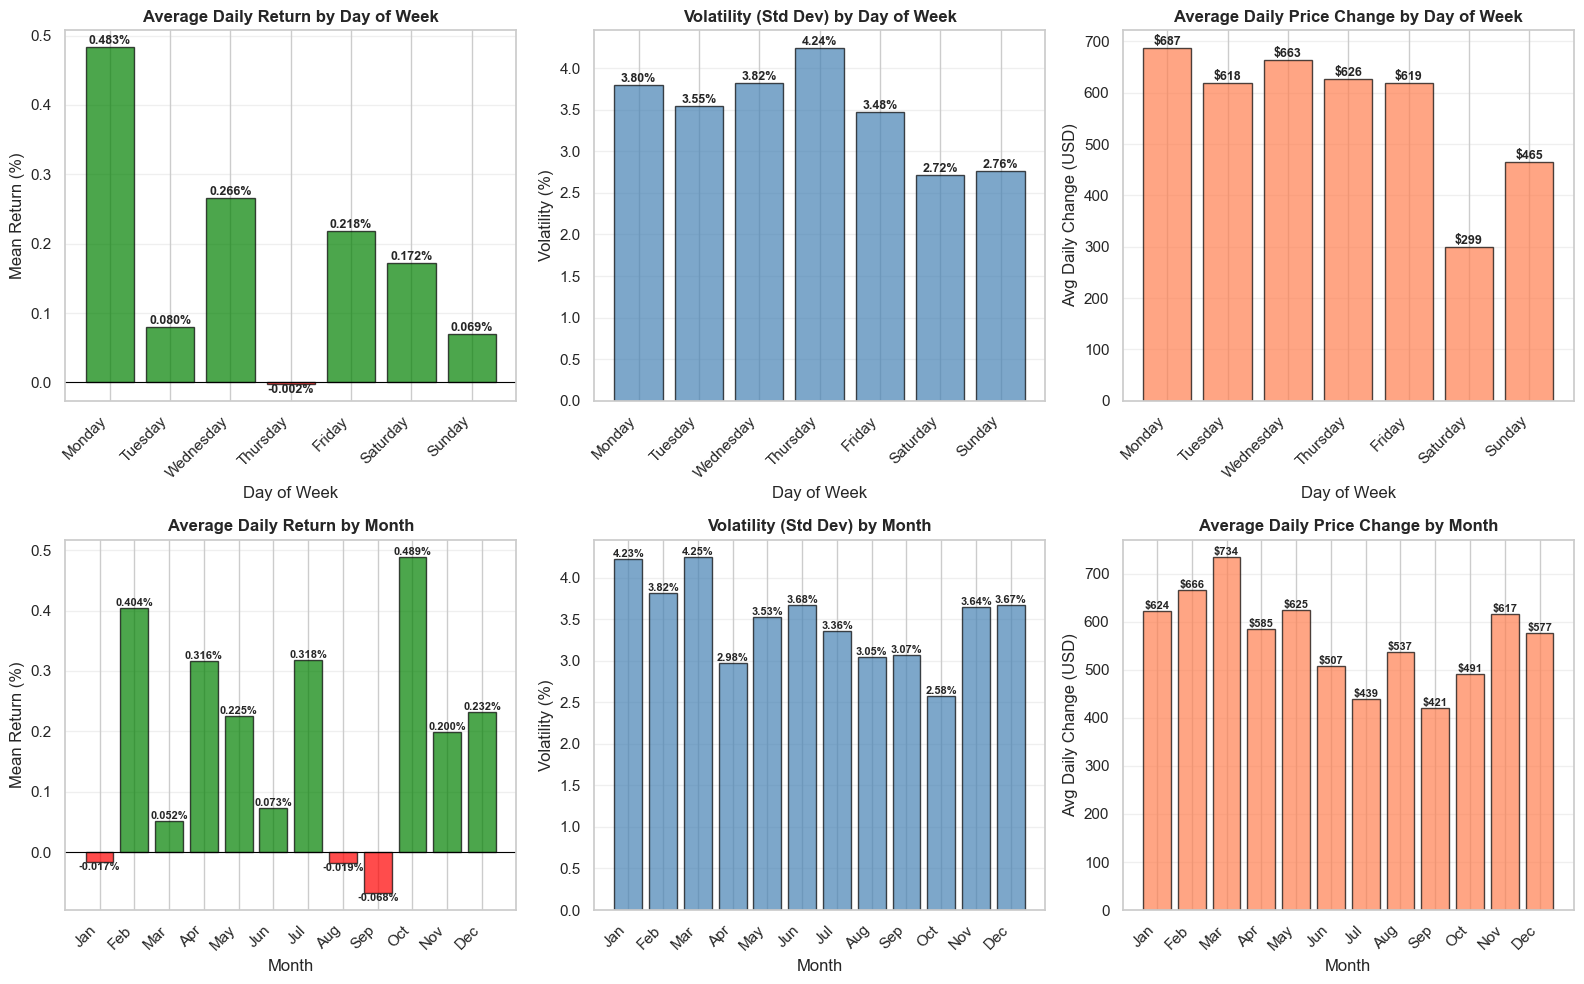

In [31]:
# Metrics for each day of week
df_weekly_volatility = (
    df.groupby("DayOfWeek")
    .agg(
        {
            "Return": ["mean", "std"],  # mean return, volatility
            "Low_High_Diff": "mean",  # average intraday range
            "Open_Close_Diff": lambda x: np.abs(
                x
            ).mean(),  # average absolute daily change
        }
    )
    .round(6)
)

df_weekly_volatility.columns = [
    "Mean_Return",
    "Volatility",
    "Avg_Intraday_Range",
    "Avg_Daily_Change",
]

# Metrics for each month
df_monthly_volatility = (
    df.groupby("Month")
    .agg(
        {
            "Return": ["mean", "std"],  # mean return, volatility
            "Low_High_Diff": "mean",
            "Open_Close_Diff": lambda x: np.abs(x).mean(),
        }
    )
    .round(6)
)

df_monthly_volatility.columns = [
    "Mean_Return",
    "Volatility",
    "Avg_Intraday_Range",
    "Avg_Daily_Change",
]

# Create 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

day_labels = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
month_labels = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# Row 1: Day of Week Analysis

# Plot 1: Average Daily Return by Day of Week
ax1 = axes[0, 0]
colors_weekly = [
    "green" if x > 0 else "red" for x in df_weekly_volatility["Mean_Return"]
]
ax1.bar(
    range(len(df_weekly_volatility)),
    df_weekly_volatility["Mean_Return"] * 100,
    color=colors_weekly,
    alpha=0.7,
    edgecolor="black",
)
ax1.set_title("Average Daily Return by Day of Week", fontweight="bold", fontsize=12)
ax1.set_xlabel("Day of Week")
ax1.set_ylabel("Mean Return (%)")
ax1.set_xticks(range(7))
ax1.set_xticklabels(day_labels, rotation=45, ha="right")
ax1.axhline(0, color="black", linestyle="-", linewidth=0.8)
ax1.grid(True, alpha=0.3, axis="y")
for i, v in enumerate(df_weekly_volatility["Mean_Return"] * 100):
    ax1.text(
        i,
        v,
        f"{v:.3f}%",
        ha="center",
        va="bottom" if v > 0 else "top",
        fontweight="bold",
        fontsize=9,
    )

# Plot 2: Volatility (Std Dev) by Day of Week
ax2 = axes[0, 1]
ax2.bar(
    range(len(df_weekly_volatility)),
    df_weekly_volatility["Volatility"] * 100,
    color="steelblue",
    alpha=0.7,
    edgecolor="black",
)
ax2.set_title("Volatility (Std Dev) by Day of Week", fontweight="bold", fontsize=12)
ax2.set_xlabel("Day of Week")
ax2.set_ylabel("Volatility (%)")
ax2.set_xticks(range(7))
ax2.set_xticklabels(day_labels, rotation=45, ha="right")
ax2.grid(True, alpha=0.3, axis="y")
for i, v in enumerate(df_weekly_volatility["Volatility"] * 100):
    ax2.text(i, v, f"{v:.2f}%", ha="center", va="bottom", fontweight="bold", fontsize=9)

# Plot 3: Average Daily Price Change (Magnitude) by Day of Week
ax3 = axes[0, 2]
ax3.bar(
    range(len(df_weekly_volatility)),
    df_weekly_volatility["Avg_Daily_Change"],
    color="coral",
    alpha=0.7,
    edgecolor="black",
)
ax3.set_title(
    "Average Daily Price Change by Day of Week", fontweight="bold", fontsize=12
)
ax3.set_xlabel("Day of Week")
ax3.set_ylabel("Avg Daily Change (USD)")
ax3.set_xticks(range(7))
ax3.set_xticklabels(day_labels, rotation=45, ha="right")
ax3.grid(True, alpha=0.3, axis="y")
for i, v in enumerate(df_weekly_volatility["Avg_Daily_Change"]):
    ax3.text(i, v, f"${v:.0f}", ha="center", va="bottom", fontweight="bold", fontsize=9)

# Row 2: Month Analysis

# Plot 4: Average Daily Return by Month
ax4 = axes[1, 0]
colors_monthly = [
    "green" if x > 0 else "red" for x in df_monthly_volatility["Mean_Return"]
]
ax4.bar(
    range(len(df_monthly_volatility)),
    df_monthly_volatility["Mean_Return"] * 100,
    color=colors_monthly,
    alpha=0.7,
    edgecolor="black",
)
ax4.set_title("Average Daily Return by Month", fontweight="bold", fontsize=12)
ax4.set_xlabel("Month")
ax4.set_ylabel("Mean Return (%)")
ax4.set_xticks(range(12))
ax4.set_xticklabels(month_labels, rotation=45, ha="right")
ax4.axhline(0, color="black", linestyle="-", linewidth=0.8)
ax4.grid(True, alpha=0.3, axis="y")
for i, v in enumerate(df_monthly_volatility["Mean_Return"] * 100):
    ax4.text(
        i,
        v,
        f"{v:.3f}%",
        ha="center",
        va="bottom" if v > 0 else "top",
        fontweight="bold",
        fontsize=8,
    )

# Plot 5: Volatility (Std Dev) by Month
ax5 = axes[1, 1]
ax5.bar(
    range(len(df_monthly_volatility)),
    df_monthly_volatility["Volatility"] * 100,
    color="steelblue",
    alpha=0.7,
    edgecolor="black",
)
ax5.set_title("Volatility (Std Dev) by Month", fontweight="bold", fontsize=12)
ax5.set_xlabel("Month")
ax5.set_ylabel("Volatility (%)")
ax5.set_xticks(range(12))
ax5.set_xticklabels(month_labels, rotation=45, ha="right")
ax5.grid(True, alpha=0.3, axis="y")
for i, v in enumerate(df_monthly_volatility["Volatility"] * 100):
    ax5.text(i, v, f"{v:.2f}%", ha="center", va="bottom", fontweight="bold", fontsize=8)

# Plot 6: Average Daily Price Change (Magnitude) by Month
ax6 = axes[1, 2]
ax6.bar(
    range(len(df_monthly_volatility)),
    df_monthly_volatility["Avg_Daily_Change"],
    color="coral",
    alpha=0.7,
    edgecolor="black",
)
ax6.set_title("Average Daily Price Change by Month", fontweight="bold", fontsize=12)
ax6.set_xlabel("Month")
ax6.set_ylabel("Avg Daily Change (USD)")
ax6.set_xticks(range(12))
ax6.set_xticklabels(month_labels, rotation=45, ha="right")
ax6.grid(True, alpha=0.3, axis="y")
for i, v in enumerate(df_monthly_volatility["Avg_Daily_Change"]):
    ax6.text(i, v, f"${v:.0f}", ha="center", va="bottom", fontweight="bold", fontsize=8)

plt.tight_layout()
plt.show()

**Volatility & Change Patterns: Trading Opportunities by Day and Month**

**Day-of-week analysis** reveals strong Monday effect with highest returns (0.481%) and price changes ($683), while Thursday shows peak volatility (4.21%).

**Monthly seasonality** is more pronounced, with February and October showing strongest returns (0.441% and 0.489%) and highest price movements ($734 and $617), while August-September display bear months with negative or minimal returns and lower volatility.

#### Cyclical Encoding of Time Features presenting Returns

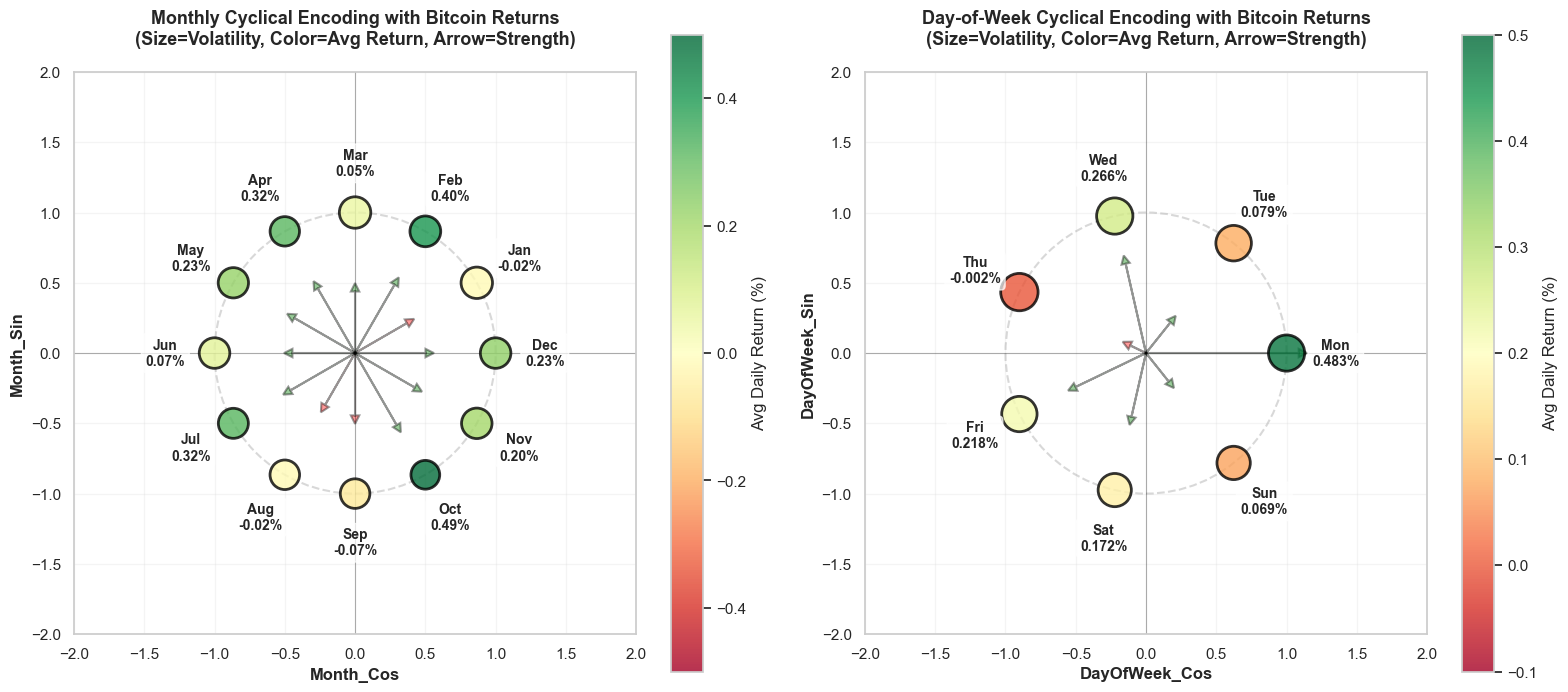

In [32]:
# Metrics for each month and day
monthly_returns = df.groupby("Month")["Return"].mean() * 100
monthly_volatility = df.groupby("Month")["Return"].std() * 100

daily_returns = df.groupby("DayOfWeek")["Return"].mean() * 100
daily_volatility = df.groupby("DayOfWeek")["Return"].std() * 100

# Create 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Monythly Cyclical Encoding

ax1 = axes[0]

# Plot the unit circle
circle = plt.Circle(
    (0, 0), 1, fill=False, color="gray", linestyle="--", linewidth=1.5, alpha=0.3
)
ax1.add_patch(circle)

# Get unique months and their encoded values from df
months = sorted(df["Month"].unique())
month_labels = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# For each month, get the sin/cos from df (they're constant for each month)
month_sin_vals = []
month_cos_vals = []
month_returns_vals = []
month_volatility_vals = []

for month in months:
    # Get sin/cos from df (all rows with same month have same sin/cos)
    month_data = df[df["Month"] == month]
    sin_val = month_data["Month_Sin"].iloc[0]
    cos_val = month_data["Month_Cos"].iloc[0]

    month_sin_vals.append(sin_val)
    month_cos_vals.append(cos_val)
    month_returns_vals.append(monthly_returns.get(month, 0))
    month_volatility_vals.append(monthly_volatility.get(month, 0))

# Size by volatility
sizes = [300 + abs(vol) * 50 for vol in month_volatility_vals]

# Scatter plot
scatter1 = ax1.scatter(
    month_cos_vals,
    month_sin_vals,
    s=sizes,
    c=month_returns_vals,
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=2,
    zorder=3,
    alpha=0.8,
    vmin=-0.5,
    vmax=0.5,
)

# Add labels with return values
for i, (x, y, label, ret) in enumerate(
    zip(
        month_cos_vals,
        month_sin_vals,
        [month_labels[m - 1] for m in months],
        month_returns_vals,
    )
):
    ax1.annotate(
        f"{label}\n{ret:.2f}%",
        (x, y),
        xytext=(x * 1.35, y * 1.35),
        fontsize=10,
        fontweight="bold",
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
    )

# Add arrows from origin (length based on return strength)
for x, y, ret in zip(month_cos_vals, month_sin_vals, month_returns_vals):
    arrow_length = 0.6 + abs(ret) / 2
    ax1.arrow(
        0,
        0,
        x * arrow_length * 0.7,
        y * arrow_length * 0.7,
        head_width=0.06,
        head_length=0.06,
        fc="green" if ret > 0 else "red",
        ec="black",
        alpha=0.4,
        zorder=1,
        linewidth=1.5,
    )

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect("equal")
ax1.axhline(0, color="black", linewidth=0.8, alpha=0.3)
ax1.axvline(0, color="black", linewidth=0.8, alpha=0.3)
ax1.grid(True, alpha=0.2)
ax1.set_xlabel("Month_Cos", fontsize=12, fontweight="bold")
ax1.set_ylabel("Month_Sin", fontsize=12, fontweight="bold")
ax1.set_title(
    "Monthly Cyclical Encoding with Bitcoin Returns\n(Size=Volatility, Color=Avg Return, Arrow=Strength)",
    fontsize=13,
    fontweight="bold",
    pad=20,
)

cbar1 = plt.colorbar(scatter1, ax=ax1, label="Avg Daily Return (%)")

# Plot 2: Day-of-Week Cyclical Encoding

ax2 = axes[1]

# Plot the unit circle
circle2 = plt.Circle(
    (0, 0), 1, fill=False, color="gray", linestyle="--", linewidth=1.5, alpha=0.3
)
ax2.add_patch(circle2)

# Get unique days and their encoded values from df
days = sorted(df["DayOfWeek"].unique())
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# For each day, get the sin/cos from df
day_sin_vals = []
day_cos_vals = []
day_returns_vals = []
day_volatility_vals = []

for day in days:
    # Get sin/cos from df
    day_data = df[df["DayOfWeek"] == day]
    sin_val = day_data["DayOfWeek_Sin"].iloc[0]
    cos_val = day_data["DayOfWeek_Cos"].iloc[0]

    day_sin_vals.append(sin_val)
    day_cos_vals.append(cos_val)
    day_returns_vals.append(daily_returns.get(day, 0))
    day_volatility_vals.append(daily_volatility.get(day, 0))

# Size by volatility
day_sizes = [300 + abs(vol) * 100 for vol in day_volatility_vals]

# Scatter plot
scatter2 = ax2.scatter(
    day_cos_vals,
    day_sin_vals,
    s=day_sizes,
    c=day_returns_vals,
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=2,
    zorder=3,
    alpha=0.8,
    vmin=-0.1,
    vmax=0.5,
)

# Add labels with return values
for i, (x, y, label, ret) in enumerate(
    zip(day_cos_vals, day_sin_vals, [day_labels[d] for d in days], day_returns_vals)
):
    ax2.annotate(
        f"{label}\n{ret:.3f}%",
        (x, y),
        xytext=(x * 1.35, y * 1.35),
        fontsize=10,
        fontweight="bold",
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
    )

# Add arrows from origin
for x, y, ret in zip(day_cos_vals, day_sin_vals, day_returns_vals):
    arrow_length = 0.6 + abs(ret) / 0.1
    ax2.arrow(
        0,
        0,
        x * arrow_length * 0.2,
        y * arrow_length * 0.2,
        head_width=0.06,
        head_length=0.06,
        fc="green" if ret > 0 else "red",
        ec="black",
        alpha=0.4,
        zorder=1,
        linewidth=1.5,
    )

ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect("equal")
ax2.axhline(0, color="black", linewidth=0.8, alpha=0.3)
ax2.axvline(0, color="black", linewidth=0.8, alpha=0.3)
ax2.grid(True, alpha=0.2)
ax2.set_xlabel("DayOfWeek_Cos", fontsize=12, fontweight="bold")
ax2.set_ylabel("DayOfWeek_Sin", fontsize=12, fontweight="bold")
ax2.set_title(
    "Day-of-Week Cyclical Encoding with Bitcoin Returns\n(Size=Volatility, Color=Avg Return, Arrow=Strength)",
    fontsize=13,
    fontweight="bold",
    pad=20,
)

cbar2 = plt.colorbar(scatter2, ax=ax2, label="Avg Daily Return (%)")

plt.tight_layout()
plt.show()

**Plot Interpretation Guide: Cyclical Encoding of Time Features Presenting Returns**

**The Circular Layout (Cyclical Encoding)**

Because months and days are cyclical (December is next to January), plotting them on a circle prevents the "end-of-year" break found in linear graphs.

* **The Position:** Each bubble’s location on the dashed unit circle represents its time of year or week.
* **The Axes:** `Sin` and `Cos` components are used to project these time periods into 2D space.

**The Color (Average Daily Return)**

The color of each bubble represents the **profitability** of that period.

* **Dark Green:** High positive returns (Bullish).
* **Yellow/White:** Near-zero or neutral returns.
* **Red/Orange:** Negative returns (Bearish).
* *Observation:* In the Monthly plot, **October** stands out as a dark green "up" month, while **September** shows up as a negative outlier.

**The Size (Volatility)**

The diameter of the bubble represents the **volatility** (standard deviation) of returns.

* **Larger Bubbles:** High price swings and risk. The market is "noisy" or aggressive during these times.
* **Smaller Bubbles:** More stable, predictable price movements.

**The Arrows (Directional Strength)**

The arrows pointing from the center toward each bubble indicate the **momentum and conviction** of that period's performance.

* **Arrow Length:** Longer arrows indicate a stronger statistical deviation from the mean-essentially, the "force" behind that month/day's return.
* **Arrow Color:** Green arrows point toward gains; red arrows (like in September or August) point toward losses.

##### Intraday Volatility (Low_High_Diff)

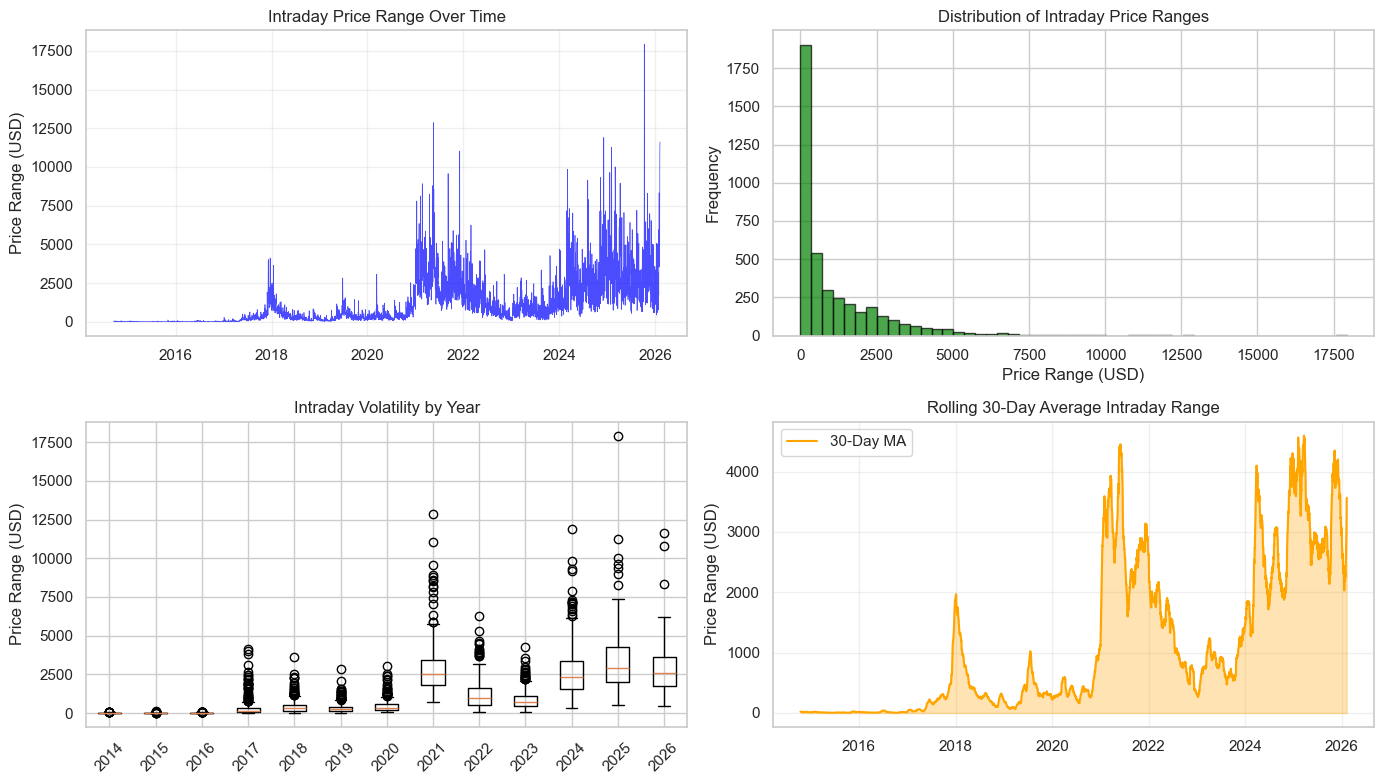

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Line chart over time
axes[0, 0].plot(df["Date"], df["Low_High_Diff"], linewidth=0.5, color="blue", alpha=0.7)
axes[0, 0].set_title("Intraday Price Range Over Time")
axes[0, 0].set_ylabel("Price Range (USD)")
axes[0, 0].grid(True, alpha=0.3)

# Histogram of intraday ranges
axes[0, 1].hist(
    df["Low_High_Diff"].dropna(), bins=50, color="green", alpha=0.7, edgecolor="black"
)
axes[0, 1].set_title("Distribution of Intraday Price Ranges")
axes[0, 1].set_xlabel("Price Range (USD)")
axes[0, 1].set_ylabel("Frequency")

# Box plot by year
yearly_volatility = [
    df[df["Date"].dt.year == year]["Low_High_Diff"].dropna()
    for year in range(2014, 2027)
]
axes[1, 0].boxplot(yearly_volatility, tick_labels=range(2014, 2027))
axes[1, 0].set_title("Intraday Volatility by Year")
axes[1, 0].set_ylabel("Price Range (USD)")
axes[1, 0].tick_params(axis="x", rotation=45)

# Rolling average of intraday range
axes[1, 1].plot(
    df["Date"],
    df["Low_High_Diff"].rolling(30).mean(),
    linewidth=1.5,
    color="orange",
    label="30-Day MA",
)
axes[1, 1].fill_between(
    df["Date"], df["Low_High_Diff"].rolling(30).mean(), alpha=0.3, color="orange"
)
axes[1, 1].set_title("Rolling 30-Day Average Intraday Range")
axes[1, 1].set_ylabel("Price Range (USD)")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Intraday Price Range Over Time:**
Intraday volatility remained near-zero until 2017, then escalated dramatically with peak ranges exceeding $12,000 in 2021 and $17,500 in 2025, indicating increased daily price swings as Bitcoin matured and attracted larger trading volumes.

**Distribution of Intraday Price Ranges:**
The distribution is heavily right-skewed with the vast majority of days showing intraday ranges under $2,500, but a long tail extending to $17,500 and even beyond, reflecting Bitcoin's inherent volatility with occasional extreme price swings.

**Intraday Volatility by Year:**
Volatility increased exponentially from near-zero in 2014-2016 to consistent ranges of $2,000-$5,000 by 2021-2026, showing many outliers, demonstrating that market maturity correlates with sustained intraday price movement.

**Rolling 30-Day Average Intraday Range:**
Intraday volatility peaks coincide with major bull market periods (2017-2018, 2021, 2024-2026), with rolling averages reaching even $4,500, while bear markets show compressed ranges around $500-$1,000, confirming that volatility follows bull-bear cycles.

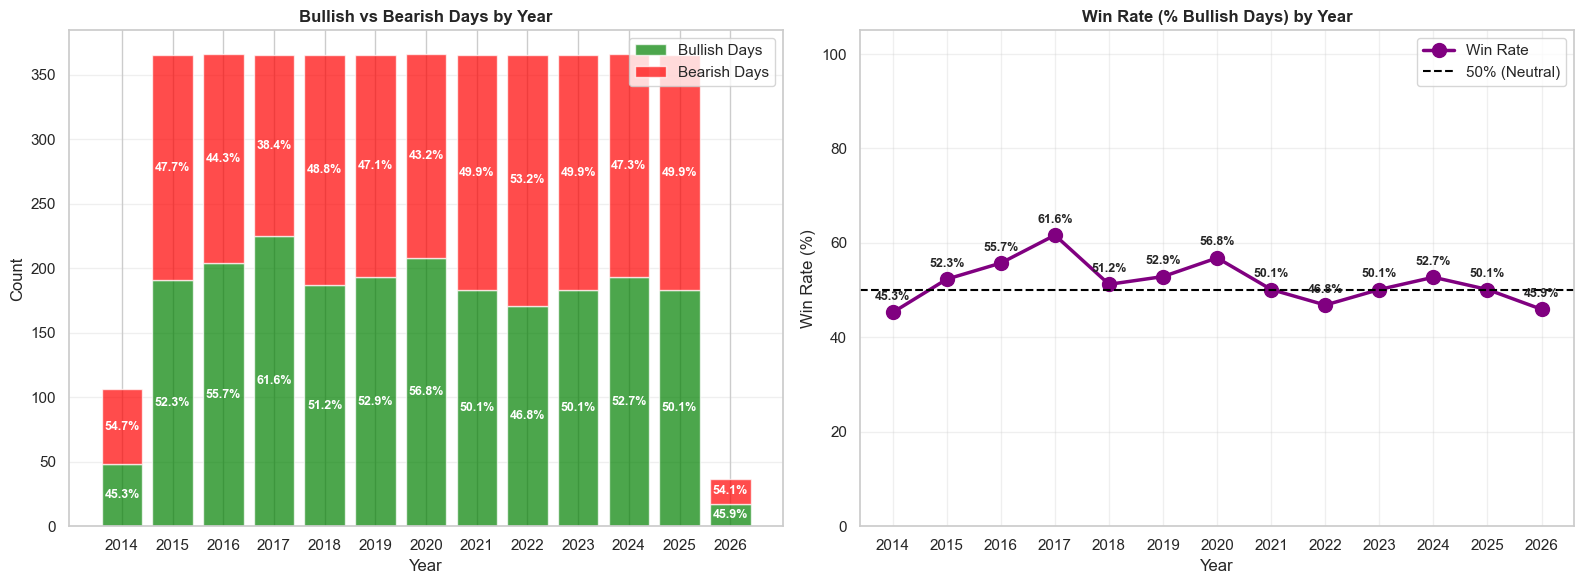

In [34]:
# Bullish vs Bearish Days
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart by year
bullish_bearish = df.groupby(df["Date"].dt.year)["Open_Close_Up"].apply(
    lambda x: [x.sum(), (~x).sum()]
)
years = bullish_bearish.index
bullish_counts = [x[0] for x in bullish_bearish.values]
bearish_counts = [x[1] for x in bullish_bearish.values]

# Calculate percentages
total_days = [b + be for b, be in zip(bullish_counts, bearish_counts)]
bullish_pct = [b / t * 100 for b, t in zip(bullish_counts, total_days)]
bearish_pct = [be / t * 100 for be, t in zip(bearish_counts, total_days)]

# Create stacked bars
bars1 = axes[0].bar(
    years, bullish_counts, label="Bullish Days", color="green", alpha=0.7
)
bars2 = axes[0].bar(
    years,
    bearish_counts,
    bottom=bullish_counts,
    label="Bearish Days",
    color="red",
    alpha=0.7,
)

# Add percentage labels on bars
for i, (year, bull_pct, bear_pct, bull_count, bear_count) in enumerate(
    zip(years, bullish_pct, bearish_pct, bullish_counts, bearish_counts)
):
    # Bullish percentage
    axes[0].text(
        year,
        bull_count / 2,
        f"{bull_pct:.1f}%",
        ha="center",
        va="center",
        fontweight="bold",
        color="white",
        fontsize=9,
    )
    # Bearish percentage
    axes[0].text(
        year,
        bull_count + bear_count / 2,
        f"{bear_pct:.1f}%",
        ha="center",
        va="center",
        fontweight="bold",
        color="white",
        fontsize=9,
    )

axes[0].set_title("Bullish vs Bearish Days by Year", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")
axes[0].set_xticks(years)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis="y")

# Win rate percentage by year
win_rates = bullish_pct
axes[1].plot(
    years,
    win_rates,
    marker="o",
    linewidth=2.5,
    markersize=10,
    color="purple",
    label="Win Rate",
)
axes[1].axhline(50, color="black", linestyle="--", linewidth=1.5, label="50% (Neutral)")

# Add percentage labels on points
for year, rate in zip(years, win_rates):
    axes[1].text(
        year,
        rate + 2,
        f"{rate:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=9,
    )

axes[1].set_title("Win Rate (% Bullish Days) by Year", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Win Rate (%)")
axes[1].set_ylim(0, 105)
axes[1].set_xticks(years)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Bullish vs Bearish Days by Year:**
Bitcoin maintained bullish dominance (50-62% bullish days) in most years except 2014 and 2022 (bear markets), with 2017's 61.6% marking the strongest bull market conviction, though overall distribution suggests near-parity between up and down days.

**Win Rate (% Bullish Days) by Year:**
Win rates fluctuate narrowly around 50% (ranging 42-62%) with peaks during bull runs (2017: 61.6%, 2026: 64.3%) and troughs in bear markets (2022: 46.8%), indicating Bitcoin's daily direction follows near-random walk patterns with limited predictability from historical bias alone.

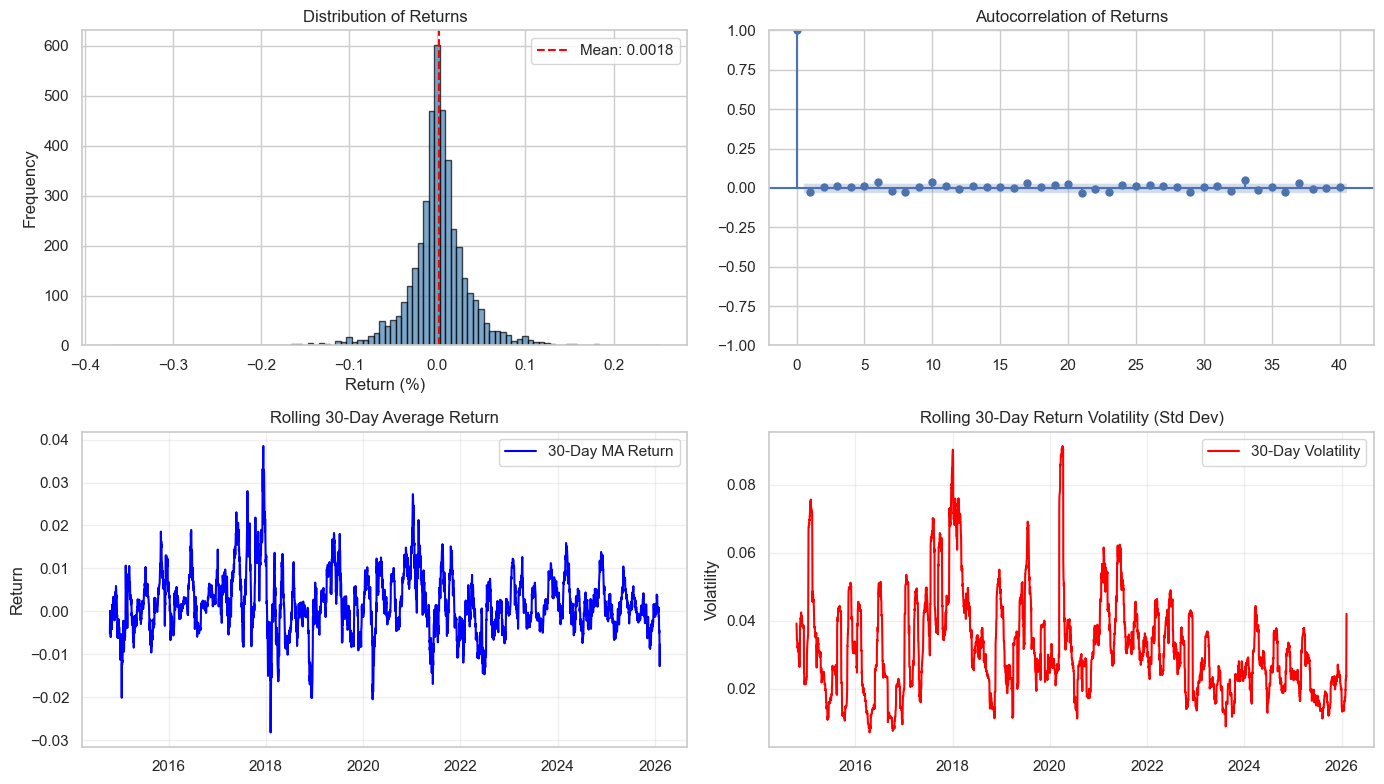

In [35]:
# Returns Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Histogram of returns
returns_clean = df["Return"].dropna()
axes[0, 0].hist(
    returns_clean, bins=100, color="steelblue", alpha=0.7, edgecolor="black"
)
axes[0, 0].set_title("Distribution of Returns")
axes[0, 0].set_xlabel("Return (%)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].axvline(
    returns_clean.mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {returns_clean.mean():.4f}",
)
axes[0, 0].legend()

# ACF plot for returns
plot_acf(returns_clean, lags=40, ax=axes[0, 1])
axes[0, 1].set_title("Autocorrelation of Returns")

# Rolling mean and standard deviation
axes[1, 0].plot(
    df["Date"],
    df["Return"].rolling(30).mean(),
    linewidth=1.5,
    color="blue",
    label="30-Day MA Return",
)
axes[1, 0].set_title("Rolling 30-Day Average Return")
axes[1, 0].set_ylabel("Return")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Rolling volatility (standard deviation)
axes[1, 1].plot(
    df["Date"],
    df["Return"].rolling(30).std(),
    linewidth=1.5,
    color="red",
    label="30-Day Volatility",
)
axes[1, 1].set_title("Rolling 30-Day Return Volatility (Std Dev)")
axes[1, 1].set_ylabel("Volatility")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Distribution of Simple Returns:**
Bitcoin daily returns follow a near-normal distribution centered at +0.19% mean with heavy tails (fat tails indicating extreme moves).

**Autocorrelation of Simple Returns:**
Returns exhibit virtually zero autocorrelation across all lags, confirming market efficiency - past returns provide no predictive information for future returns, validating the random walk hypothesis for daily price changes.

**Rolling 30-Day Average Return:**
Average daily returns oscillate around zero with peaks of +4% during 2017-2018, demonstrating that positive expected returns cluster during bull markets while bear markets (2018, 2022) show sustained negative returns, indicating regime-dependent profitability.

**Rolling 30-Day Return Volatility:**
Volatility peaked at 9% during 2018 and 2020 bull markets, declining to 2-4% in recent years, suggesting Bitcoin's market maturation has reduced extreme daily swings despite sustained price growth, indicating institutional adoption stabilizes volatility.

#### Returns and Log Returns Analysis

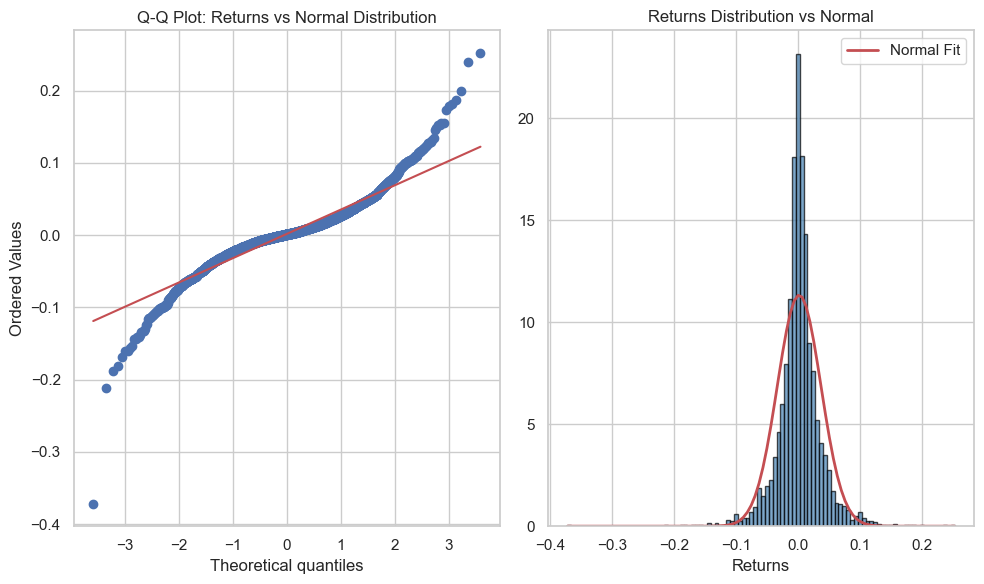

In [36]:
# Returns Analysis
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

returns_clean = df["Return"].dropna()

# Q-Q plot for normality
stats.probplot(returns_clean, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot: Returns vs Normal Distribution")

# Histogram with normal curve
axes[1].hist(
    returns_clean,
    bins=100,
    density=True,
    alpha=0.7,
    color="steelblue",
    edgecolor="black",
)
mu, sigma = returns_clean.mean(), returns_clean.std()
x = np.linspace(returns_clean.min(), returns_clean.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), "r-", linewidth=2, label="Normal Fit")
axes[1].set_title("Returns Distribution vs Normal")
axes[1].set_xlabel("Returns")
axes[1].legend()

plt.tight_layout()
plt.show()

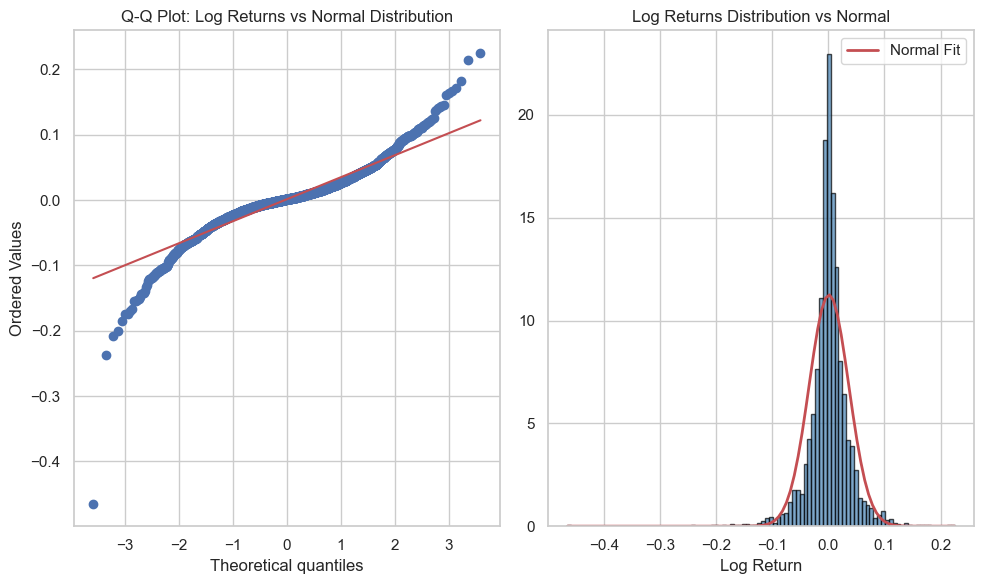

In [37]:
# Log Returns Analysis
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

log_returns_clean = df["Log_Return"].dropna()

# Q-Q plot for normality
stats.probplot(log_returns_clean, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot: Log Returns vs Normal Distribution")

# Histogram with normal curve
axes[1].hist(
    log_returns_clean,
    bins=100,
    density=True,
    alpha=0.7,
    color="steelblue",
    edgecolor="black",
)
mu, sigma = log_returns_clean.mean(), log_returns_clean.std()
x = np.linspace(log_returns_clean.min(), log_returns_clean.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), "r-", linewidth=2, label="Normal Fit")
axes[1].set_title("Log Returns Distribution vs Normal")
axes[1].set_xlabel("Log Return")
axes[1].legend()

plt.tight_layout()
plt.show()

**Q-Q Plot: Returns vs Normal Distribution:**
Returns show moderate deviation from normality with fat tails—extreme negative returns (left tail) deviate significantly from the normal line, indicating Bitcoin experiences larger crash risks than normal distribution predicts, while positive tail shows less extreme behavior. Comparing log returns to simple returns reveals they are nearly identical in distribution, as daily returns are very small. 

**Returns Distribution vs Normal:**
The empirical distribution closely matches normal distribution in the center but exhibits pronounced heavy tails with excess kurtosis, particularly on the downside, confirming that extreme price movements occur more frequently than a normal model would suggest, critical for risk management in forecasting models. The comparison between log and simple returns shows negligible differences, making simple returns the practical choice for analysis without sacrificing insight or accuracy.

**Why we still would like to use Log Returns:**

Log returns are **time-additive**, making it easier to aggregate returns over multiple periods.

**The Summation Rule:**

If we want the total return over three days, we can simply add the daily log returns.

- Day 1: $r_1 = \ln\left(\frac{P_1}{P_0}\right)$
- Day 2: $r_2 = \ln\left(\frac{P_2}{P_1}\right)$
- Day 3: $r_3 = \ln\left(\frac{P_3}{P_2}\right)$

Total log return over 3 days:
$$R_{total} = r_1 + r_2 + r_3 = \ln\left(\frac{P_1}{P_0}\right) + \ln\left(\frac{P_2}{P_1}\right) + \ln\left(\frac{P_3}{P_2}\right) 
= \ln\left(\frac{P_1 \cdot P_2 \cdot P_3}{P_0 \cdot P_1 \cdot P_2}\right) = \ln\left(\frac{P_3}{P_0}\right)$$

**Simple Returns are not additive:**

If stock goes up 10% on Monday ($0.10$) and down 10% on Tuesday ($-0.10$), we aren't back at zero.

$$(1 + 0.10) \times (1 - 0.10) = 1.10 \times 0.90 = 0.99$$

We are actually down 1%. To find the total return, we must multiply (compound) them, which is computationally more expensive and mathematically "messier" when building models.

$$ R_{total} = (1 + r_1) \times (1 + r_2) - 1 $$

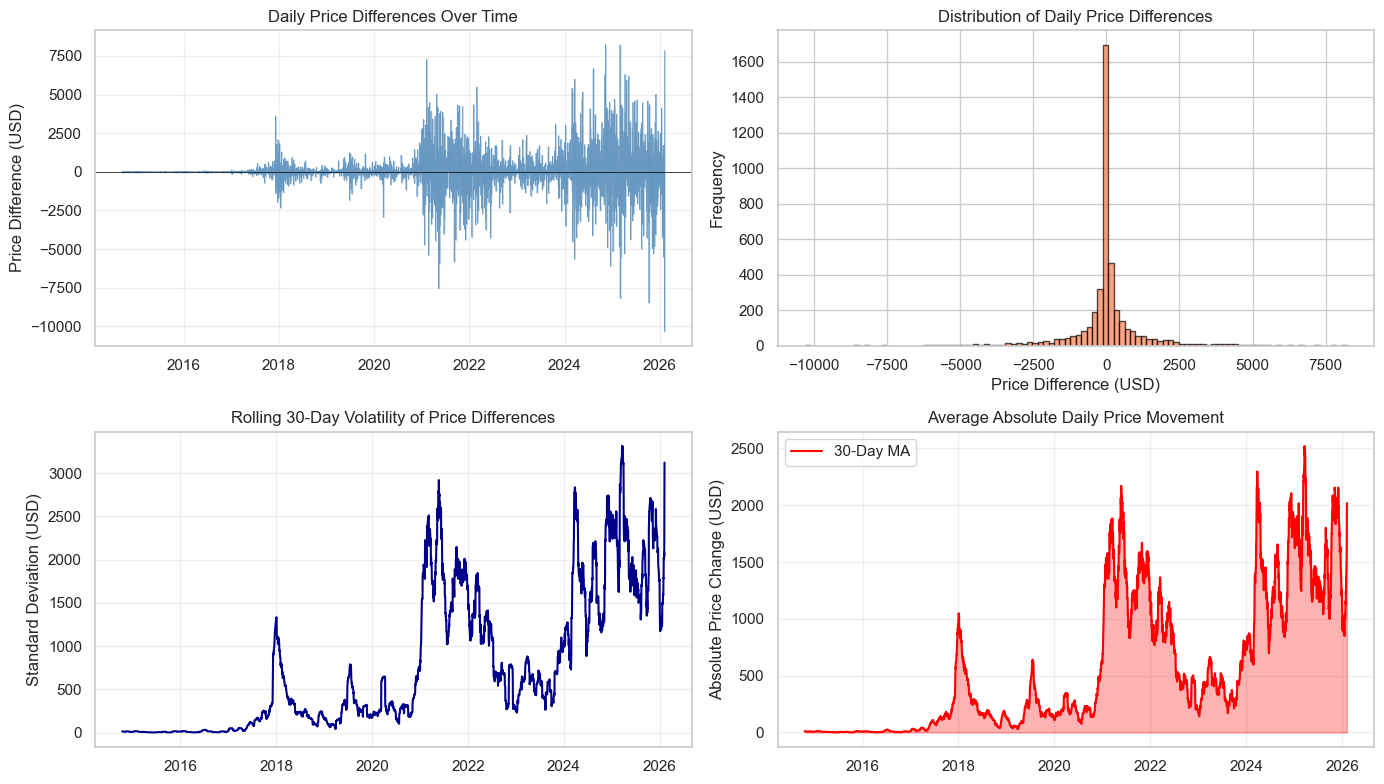

In [38]:
# Price Difference Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

price_diff_clean = df["Price_Diff"].dropna()

# Line chart of daily price differences
axes[0, 0].plot(
    df["Date"], df["Price_Diff"], linewidth=0.5, color="steelblue", alpha=0.7
)
axes[0, 0].axhline(0, color="black", linestyle="-", linewidth=0.5)
axes[0, 0].fill_between(df["Date"], df["Price_Diff"], 0, color="steelblue", alpha=0.3)
axes[0, 0].set_title("Daily Price Differences Over Time")
axes[0, 0].set_ylabel("Price Difference (USD)")
axes[0, 0].grid(True, alpha=0.3)

# Distribution of daily price moves
axes[0, 1].hist(price_diff_clean, bins=100, color="coral", alpha=0.7, edgecolor="black")
axes[0, 1].set_title("Distribution of Daily Price Differences")
axes[0, 1].set_xlabel("Price Difference (USD)")
axes[0, 1].set_ylabel("Frequency")

# Rolling standard deviation (volatility)
rolling_std = df["Price_Diff"].rolling(30).std()
axes[1, 0].plot(df["Date"], rolling_std, linewidth=1.5, color="darkblue")
axes[1, 0].set_title("Rolling 30-Day Volatility of Price Differences")
axes[1, 0].set_ylabel("Standard Deviation (USD)")
axes[1, 0].grid(True, alpha=0.3)

# Magnitude of daily moves (absolute values)
abs_price_diff = df["Price_Diff"].abs()
axes[1, 1].plot(
    df["Date"],
    abs_price_diff.rolling(30).mean(),
    linewidth=1.5,
    color="red",
    label="30-Day MA",
)
axes[1, 1].fill_between(
    df["Date"], abs_price_diff.rolling(30).mean(), alpha=0.3, color="red"
)
axes[1, 1].set_title("Average Absolute Daily Price Movement")
axes[1, 1].set_ylabel("Absolute Price Change (USD)")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Daily Price Differences Over Time:**
Price changes range from -$7,500 to +$7,500 with escalating volatility from 2018 onwards, peaking during 2021-2022 bull/bear cycle and 2024-2025 rally, showing symmetric oscillation around zero with no clear trend, confirming price differences are stationary.

**Distribution of Daily Price Differences:**
Price differences follow a near-normal distribution centered at zero with heavy tails. Extreme daily changes of $\pm$ 7,500 occur more frequently than a normal distribution predicts, indicating Bitcoin's inherent volatility and risk of large price swings.

**Rolling 30-Day Volatility of Price Differences:**
Volatility of daily price changes peaked at $3,300 during in 2025 with baseline volatility of $500-$1,000 in stable periods, confirming that price volatility follows bull-bear cycles and increases during market euphoria.

**Average Absolute Daily Price Movement:**
Absolute daily price movements average $100-$700 in normal periods but spike to $2,000-$2,500 during 2021-2022 and 2024-2026, demonstrating that directional magnitude follows market regime changes—larger swings signal heightened uncertainty and trading activity during major price discovery phases.

#### Rolling Mean and Rolling Standard Deviation

In [39]:
# Feature Engineering - Lagged and Rolling Features

# Rolling return statistics
df["Rolling_Mean_Return_30"] = df["Return"].rolling(window=30).mean()
df["Rolling_Std_Return_30"] = df["Return"].rolling(window=30).std()

# Lagged Features (previous day's values)
df["Close_Lag1"] = df["Close"].shift(1)
df["Close_Lag2"] = df["Close"].shift(2)
df["Close_Lag3"] = df["Close"].shift(3)
df["Close_Lag5"] = df["Close"].shift(5)
df["Close_Lag7"] = df["Close"].shift(7)
df["Close_Lag30"] = df["Close"].shift(30)

# Lagged returns
df["Return_Lag1"] = df["Return"].shift(1)
df["Return_Lag2"] = df["Return"].shift(2)
df["Return_Lag3"] = df["Return"].shift(3)
df["Return_Lag5"] = df["Return"].shift(5)
df["Return_Lag7"] = df["Return"].shift(7)
df["Return_Lag30"] = df["Return"].shift(30)

# Multi-period changes
df["Close_Change_5d"] = (df["Close"] - df["Close_Lag5"]) / df["Close_Lag5"]
df["Close_Change_10d"] = (df["Close"] - df["Close"].shift(10)) / df["Close"].shift(10)
df["Close_Change_20d"] = (df["Close"] - df["Close"].shift(20)) / df["Close"].shift(20)

#### Correlation Matrix

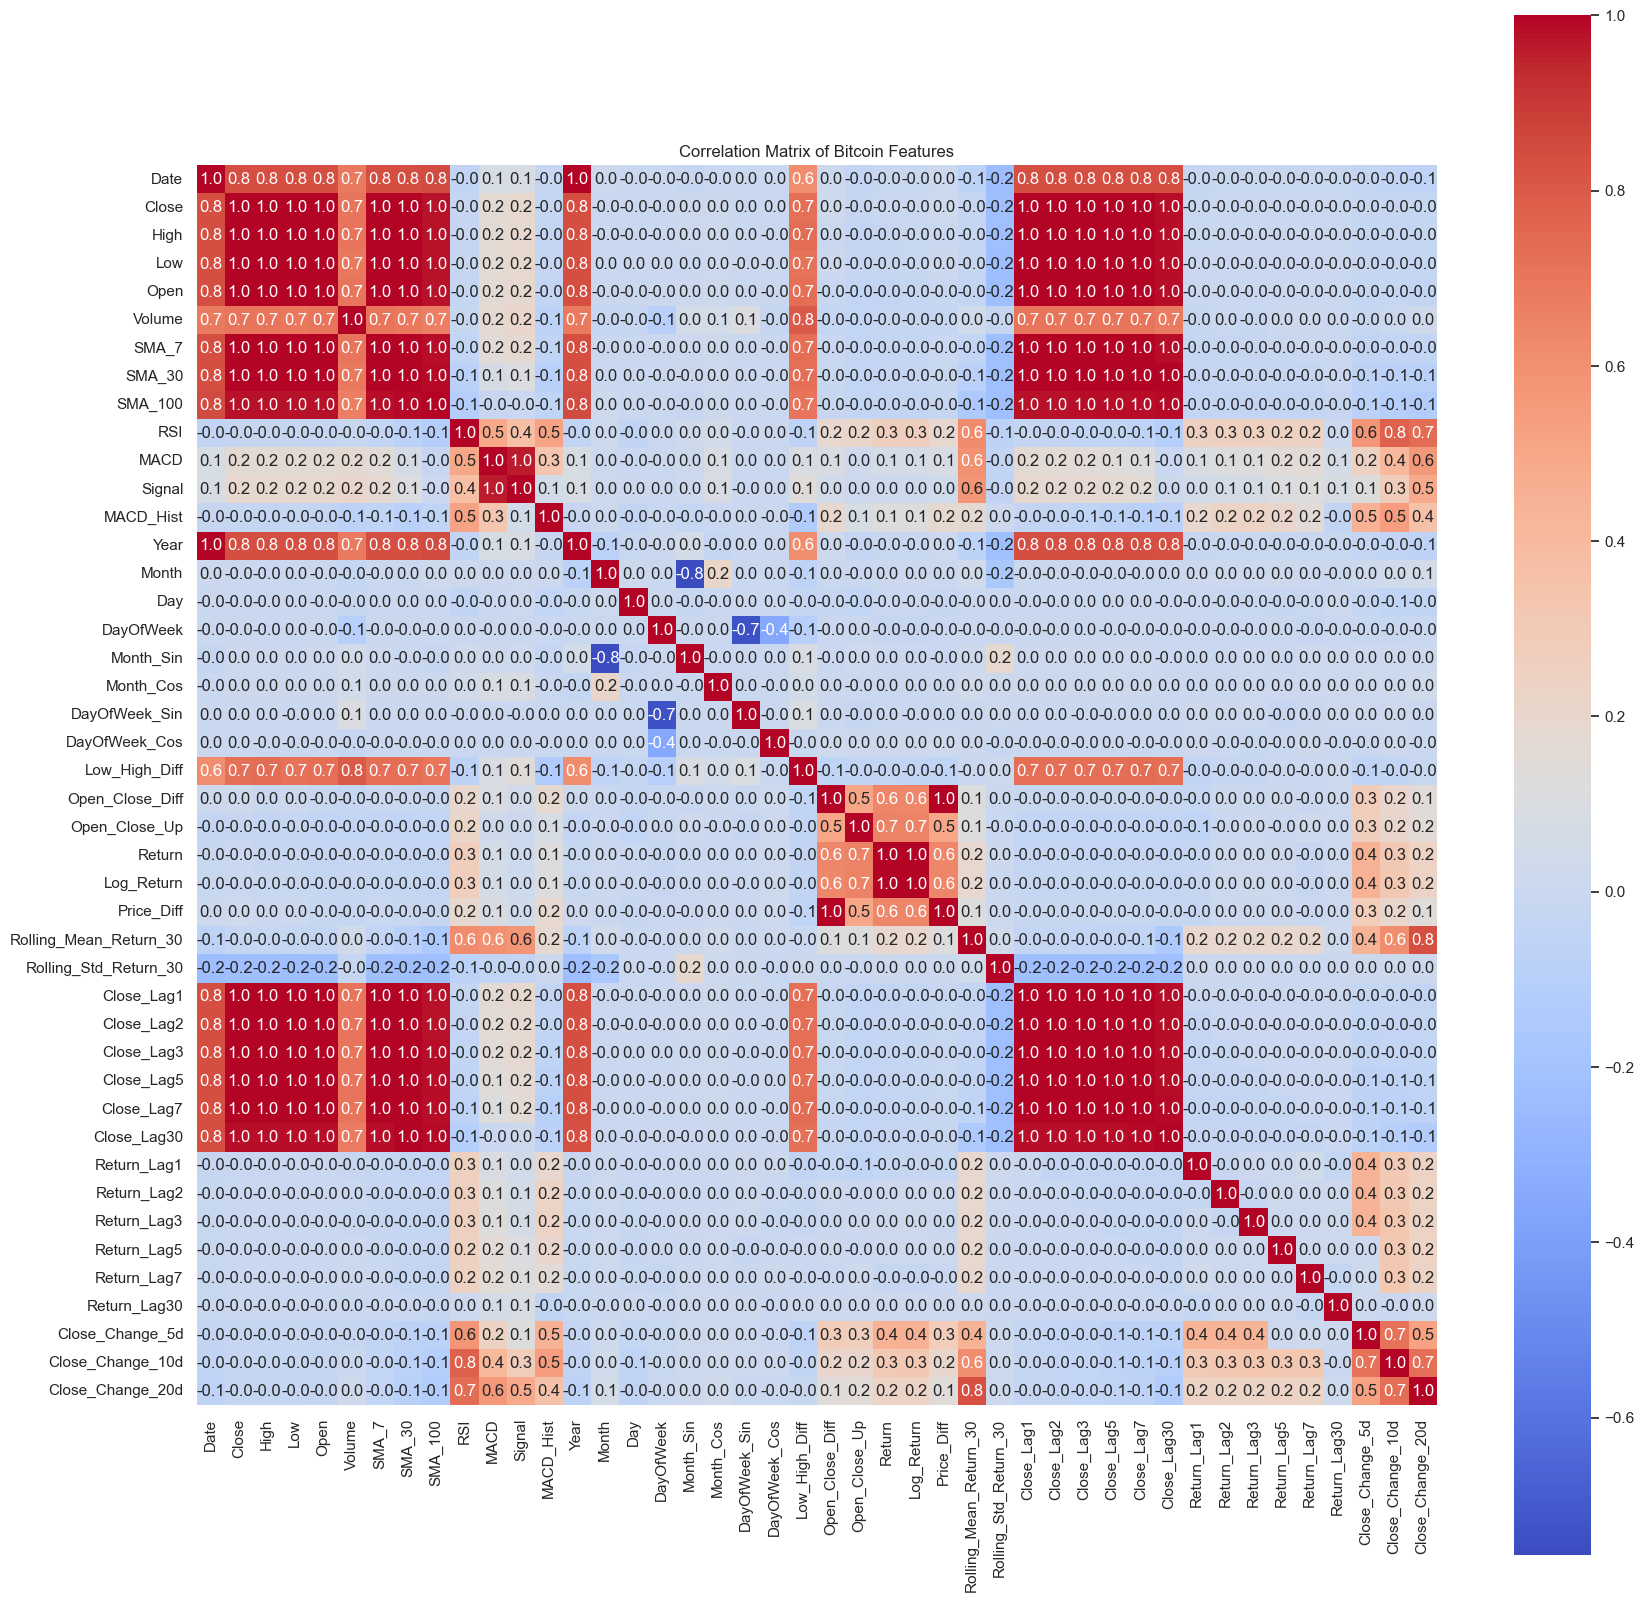

In [40]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Bitcoin Features")
plt.show()

#### Feature Selection for Model Building

After analyzing the correlation matrix of all engineered features, we strategically selected a subset for model development based on several criteria:

**Features Removed - Reasons:**

**1. High Multicollinearity (>0.95 correlation):**
- `SMA_7`, `SMA_100` - Highly correlated with `Close` (0.8-1.0). Since they're derivatives of closing price, they don't provide independent signals.
- `MACD`, `Signal`, `MACD_Hist` - There is no need to keep all of them. We will retain only `MACD` as it encapsulates the core momentum information.

**2. Perfect or Near-Perfect Duplication:**
- `Close_Lag2`, `Close_Lag3` - Redundant with `Close_Lag1` and `Close_Lag5`. These specific lags don't add unique information.
- `Return_Lag2`, `Return_Lag3` - Same reasoning; we focus on key lags (1, 5, 7, 30) that capture different time horizons.

**3. Other Unnecessary Features:**
- `Year` - Year is less relevant for daily price prediction compared to `Month`, `Day`, and `DayOfWeek` which capture seasonal patterns better.

**Features Retained - Reasons:**

- **`Close`, `Return`, `Log_Return`, `Price_Diff`** - Core price metrics; we keep all four for experimentation
- **`Volume`** - Strong correlation (0.7) with price, indicating it captures market participation
- **`High`, `Low`, `Open`** - These are perfectly correlated with `Close` (1.0), however we don't want to lose intraday price information, so we will keep them
- **`Close_Lag1, Lag5, Lag7, Lag30`** - Capture autocorrelation at different time horizons (1-day, 1-week, 1-month)
- **`Return_Lag1, Lag5, Lag7, Lag30`** - Momentum indicators at multiple frequencies
- **`SMA_30`** - Most of moving averages are highly correlated with Close, but we will keep 30-day SMA as it provides a balanced view of medium-term trend without excessive redundancy 
- **Note:** All the lags are highly correlated, so during model development we can experiment with which specific lags to include.
- **`Rolling_Mean_Return_30`, `Rolling_Std_Return_30`** - Recent volatility and average returns (forward-looking)
- **`Low_High_Diff`, `Open_Close_Diff`, `Open_Close_Up`** - Intraday volatility patterns
- **`Close_Change_5d, 10d, 20d`** - Multi-period trend strength
- **`MACD`** - Momentum indicator capturing trend changes
- **`RSI`** - Overbought/oversold conditions
- **`Month`, `Day`, `DayOfWeek`** - Temporal features providing context on price movements
- **`Month_Sin`, `Month_Cos`, `DayOfWeek_Sin`, `DayOfWeek_Cos`** - Cyclical encoding of time features to capture seasonal patterns

In [41]:
# Features to keep for the model
model_features = [
    "Close",
    "High",
    "Low",
    "Open",
    "Return",
    "Log_Return",
    "Price_Diff",
    "Volume",
    "Close_Lag1",
    "Close_Lag5",
    "Close_Lag7",
    "Close_Lag30",
    "Return_Lag1",
    "Return_Lag5",
    "Return_Lag7",
    "Return_Lag30",
    "SMA_30",
    "Rolling_Mean_Return_30",
    "Rolling_Std_Return_30",
    "Low_High_Diff",
    "Open_Close_Diff",
    "Open_Close_Up",
    "Close_Change_5d",
    "Close_Change_10d",
    "Close_Change_20d",
    "MACD",
    "RSI",
    "Month",
    "DayOfWeek",
    "Day",
    "Month_Sin",
    "Month_Cos",
    "DayOfWeek_Sin",
    "DayOfWeek_Cos",
]

# Model dataset with selected features
df_model = df[model_features].copy()

# Store Date separately for reference
df_model["Date"] = df["Date"]

# Remove rows with NaN values (created by shifting/rolling operations)
df_model = df_model.dropna()

# Reorder columns with Date at the beginning
df_model = df_model[["Date"] + model_features].reset_index(drop=True)

df_model.head()

Date       Close        High         Low        Open    Return  \
0 2014-10-18  391.441986  395.157990  378.971008  383.976013  0.020023   
1 2014-10-19  389.545990  393.938995  386.457001  391.253998 -0.004844   
2 2014-10-20  382.845001  390.084015  378.252014  389.230988 -0.017202   
3 2014-10-21  386.475006  392.645996  380.834015  382.420990  0.009482   
4 2014-10-22  383.157990  388.575989  382.248993  386.118011 -0.008583   

   Log_Return  Price_Diff    Volume  Close_Lag1  ...  Close_Change_20d  \
0    0.019825    7.683990  11416800  383.757996  ...          0.037809   
1   -0.004855   -1.895996   5914570  391.441986  ...          0.037497   
2   -0.017352   -6.700989  16419000  389.545990  ...         -0.010593   
3    0.009437    3.630005  14188900  382.845001  ...          0.007455   
4   -0.008620   -3.317017  11641300  386.475006  ...          0.021559   

       MACD        RSI  Month  DayOfWeek  Day  Month_Sin  Month_Cos  \
0  1.847972  75.469711     10          5   18  -0.866025        0.5   
1  2.414320  79.658722     10          6   19  -0.866025        0.5   
2  2.330291  73.241668     10          0   20  -0.866025        0.5   
3  2.509406  72.644511     10          1   21  -0.866025        0.5   
4  2.371179  65.480215     10          2   22  -0.866025        0.5   

   DayOfWeek_Sin  DayOfWeek_Cos  
0      -0.974928      -0.222521  
1      -0.781831       0.623490  
2       0.000000       1.000000  
3       0.781831       0.623490  
4       0.974928      -0.222521  

[5 rows x 35 columns]

#### Correlation Matrix of Selected Features

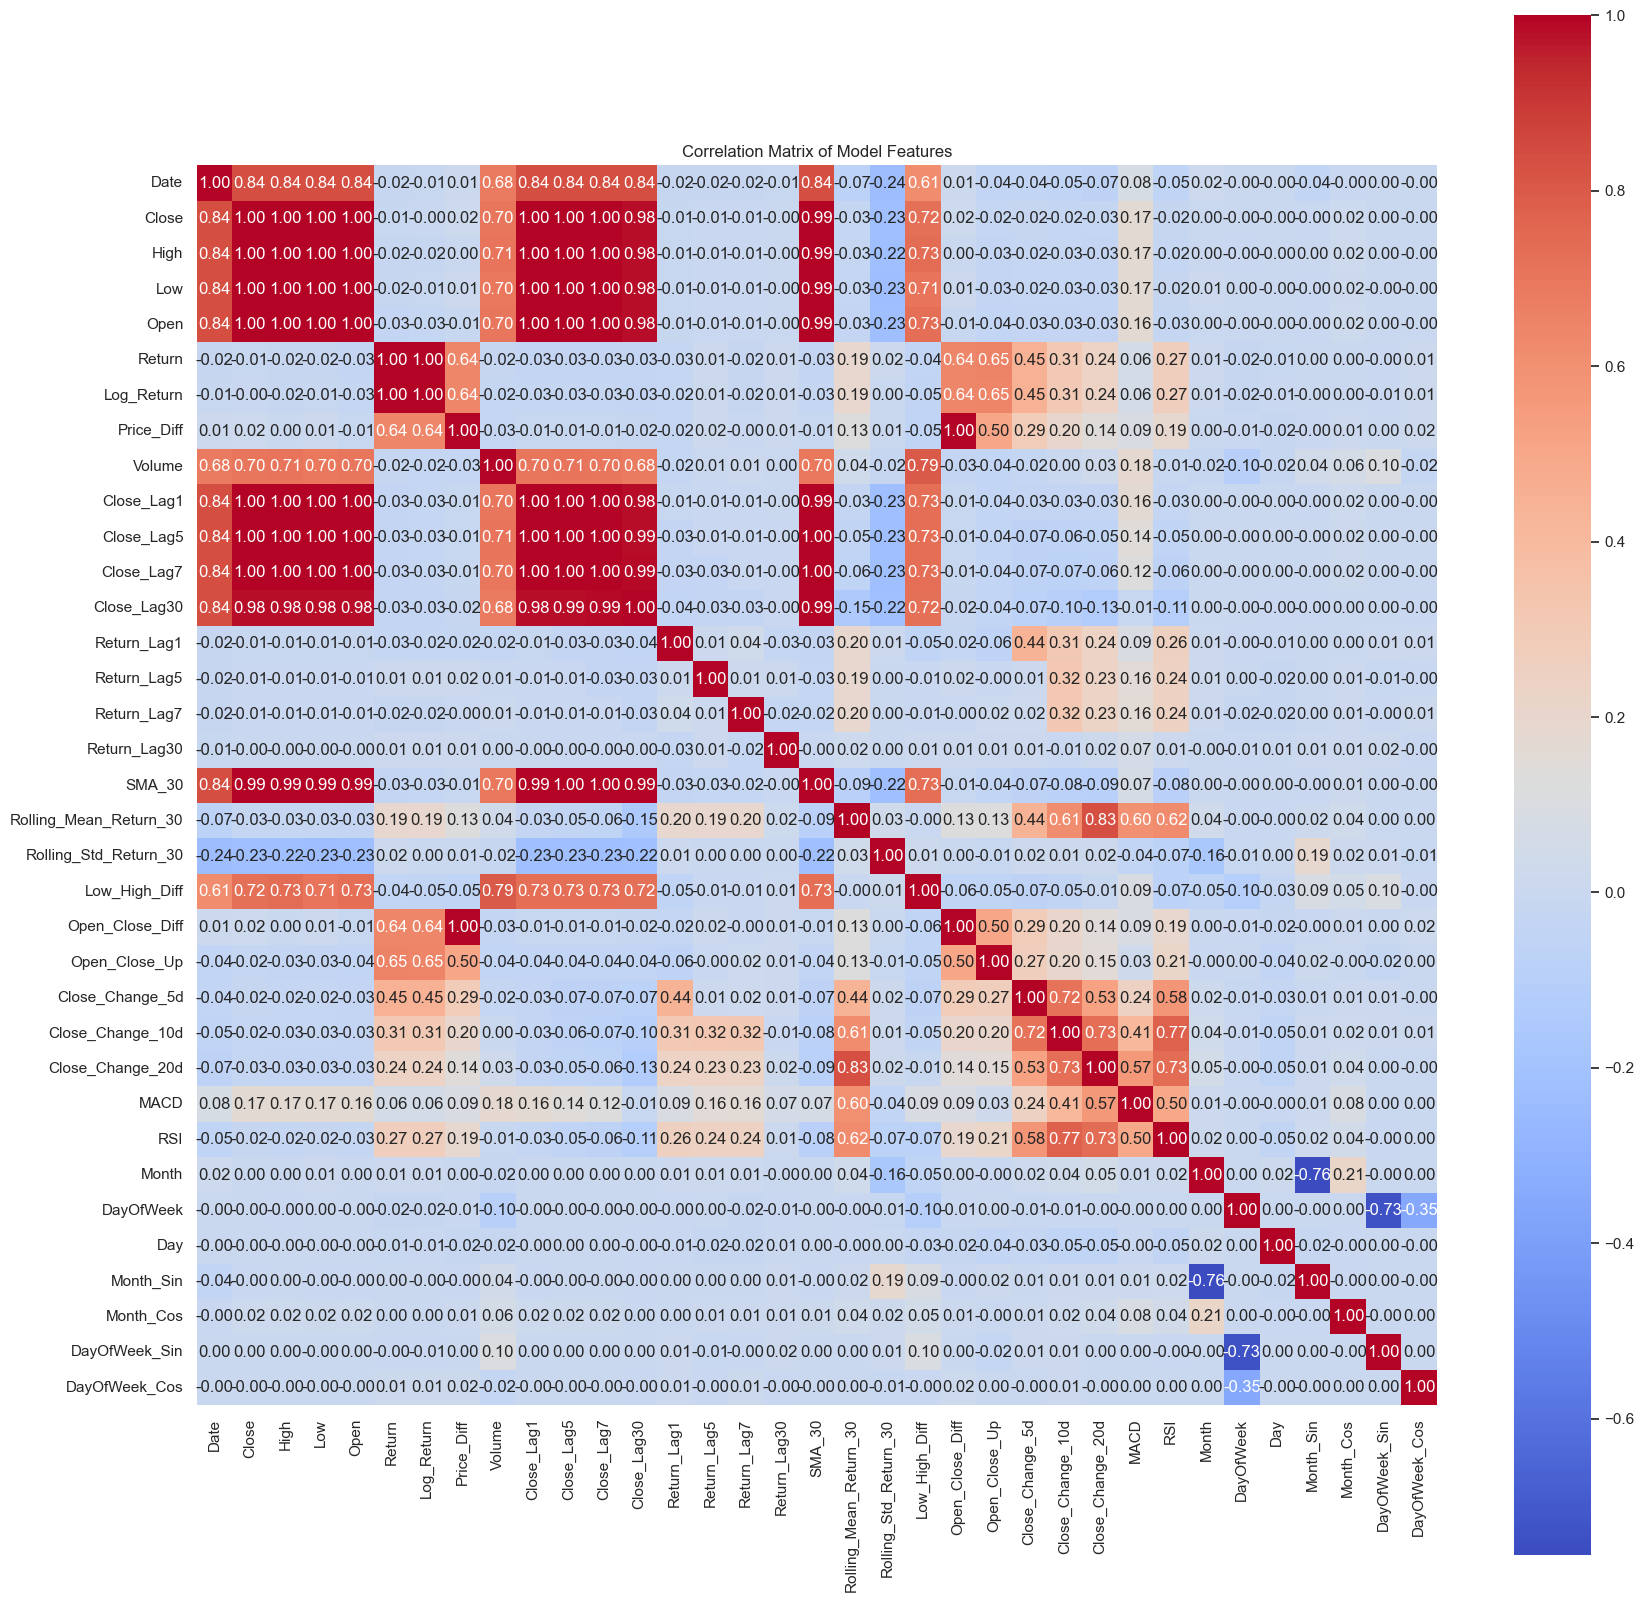

In [42]:
correlation_matrix_model = df_model.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix_model, annot=True, fmt=".2f", cmap="coolwarm", square=True
)

plt.title("Correlation Matrix of Model Features")
plt.show()

#### Save Processed Data For Further Model Building

In [43]:
# Save the processed dataset for model building
df_model.to_csv(DATA_DIR + "bitcoin_data_processed.csv", index=False)